<a href="https://colab.research.google.com/github/harrisonmack/proptech/blob/main/PropTech_Deal_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏗️ Four Years of Tracking PropTech Funding
**Author:** Harrison Mack  
**Date:** 09/14/2021 to 09/14/2025  

---

### Project Overview

This notebook walks through a structured data exploration of venture rounds tracked over the last four years.  

I’ve been deeply interested in how technology reshapes real estate and the built environment since my time with MetaProp Ventures. I’ve followed major publications and leading PropTech funds on a daily basis, capturing nearly every reported funding round into a single dataset. This effort was less about building a “perfect” database, and more about maintaining tabs on new entrants disrupting verticals for my personal curiousity.

---

### Data Provenance & Limitations
- **Source of data:** Tracked manually from industry news outlets, press releases, and insights shared by leading PropTech venture funds.  
- **Frequency:** Recorded daily over a four-year period to capture rounds as they were announced.  
- **Scope:** Focused on venture funding in proptech and the broader built world ecosystem; not an exhaustive global database, but a curated record reflecting reported and publicly available information.  
- **Limitations:**  
  - Undisclosed or unreported rounds are not included.  
  - Stage and sector categorizations reflect my judgment at the time of entry and may not perfectly match company press language.  
  - Dollar amounts represent publicly reported values, generally rounded to the nearest million USD.  

This context is important: the dataset is best seen as a living chronicle of industry dynamics, not a definitive ledger.  

---


### Table of Contents  
- **1. Setup & Config**  
- **2. Data Ingest & Schema Check**  
- **3. Cleaning Pipeline**  
- **4. Descriptive Summary**  
- **5. Visualizations**  
- **6. Trend & Insight Pass**  
- **7. Sanity Checks & Reproducibility**  
- **8. Appendix (optional)**  

---


# 1. Setup & Config
# =========================================================

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from dateutil import parser
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Colab + Drive
from google.colab import drive
import os

# ---------------------------------------------------------
# Mount Google Drive (for file access)
# ---------------------------------------------------------
drive.mount('/content/drive', force_remount=True)

# Define two save roots: Colab + Drive
OUT_DIR = "/content/cleaned_outputs"
DRIVE_DIR = "/content/drive/My Drive/PropTech_Data/exports"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(DRIVE_DIR, exist_ok=True)


Mounted at /content/drive


In [ ]:
# ---------------------------------------------------------
# Utility: Save file to both Google Drive and local machine
# ---------------------------------------------------------
import shutil
from google.colab import files

def save_both(src_path):
    """
    Save a file into Google Drive exports folder and also
    trigger a download to local machine.
    """
    if not os.path.exists(src_path):
        print(f"File not found: {src_path}")
        return
    fname = os.path.basename(src_path)

    # Copy to Drive
    dst_drive = os.path.join(DRIVE_DIR, fname)
    shutil.copy(src_path, dst_drive)
    print(f"Copied to Google Drive: {dst_drive}")

    # Trigger download
    files.download(src_path)

In [ ]:
# ---------------------------------------------------------
# Config: update paths / filters here
# ---------------------------------------------------------
CONFIG = {
    "excel_file_path": "/content/drive/My Drive/PropTech_Data/PropTech_Funding_DataFrame.xlsx",
    "sheet_name": 0,                # Default to first sheet
    "date_column": "Funding Date",  # Will be standardized later
    "round_size_column": "Round Size ($MM USD)",
    "sector_filter": None,          # e.g., ["Construction", "Residential"]
    "start_year": None,             # e.g., 2019
    "end_year": None,               # e.g., 2023
    "use_plotly": True,             # Switch between Plotly (interactive) or Matplotlib
    "random_seed": 42
}

np.random.seed(CONFIG["random_seed"])

In [ ]:
# ---------------------------------------------------------
# Load dataset
# ---------------------------------------------------------
try:
    df = pd.read_excel(CONFIG["excel_file_path"], sheet_name=CONFIG["sheet_name"])
    print(f"✅ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
    display(df.head())
except FileNotFoundError:
    print(f"❌ Error: File not found at {CONFIG['excel_file_path']}")
except Exception as e:
    print(f"❌ An error occurred while reading Excel: {e}")

✅ Data loaded successfully: 1804 rows, 8 columns


,Company Name,General Description,Stage / Round,Round Size ($MM USD),Funding Date,Raised To Date ($MM USD),Sector,Lead Investor(s)
0,Versatile,AI Construction Tech,Series B,80,09-2021,108.5,Construction,Insight Partners
1,Bilt Rewards,Credit Card for Renter Credit,Early,60,09-2021,63.9,FinTech,WF / Mastercard
2,GoodLeap,RoofTop Solar Financing,Secondary Mkt,1000,09-2021,1800.0,Residential,NaN
3,June Homes,Short Term Rental / Fix Flip,Series B,50,09-2021,50.0,Hospitality,Softbank
4,Spotnana,"SaaS, Travel Agency Operations",Series A,41,09-2021,41.0,Hospitality,"ICONIQ, Madrona Venture Group"


In [ ]:
# ---------------------------------------------------------
# Pandas display options
# ---------------------------------------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:,.2f}".format)

In [ ]:
# ---------------------------------------------------------
# Utilities: Quick Data Summary (Section 1)
# ---------------------------------------------------------
from IPython.display import display, Markdown

def quick_data_summary(
    df: pd.DataFrame,
    date_col: str = None,
    amount_col: str = None,
    preview_rows: int = 5
):
    """
    Prints a concise overview of the loaded dataset:
    - Shape, memory usage
    - Column schema with dtypes and missingness
    - Optional date coverage and basic stats for amount column
    - Head preview (first N rows)
    """
    if df is None or df.empty:
        print("DataFrame is empty or not loaded.")
        return

    # Basic meta
    rows, cols = df.shape
    mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"Dataset Overview")
    print(f"Rows: {rows:,} | Columns: {cols:,} | Memory: {mem_mb:,.2f} MB")

    # Schema table
    schema_df = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "non_null": df.notna().sum().values,
        "missing_pct": (df.isna().mean() * 100).round(2).values
    })
    display(schema_df)

    # Optional: date coverage
    if date_col and date_col in df.columns:
        # Try to parse dates without mutating original df
        dates = pd.to_datetime(df[date_col], errors="coerce")
        n_parsed = dates.notna().sum()
        if n_parsed > 0:
            dmin, dmax = dates.min(), dates.max()
            print(f"{date_col} parsed for {n_parsed:,} rows "
                  f"({n_parsed/rows*100:.1f}%). Range: {dmin.date()} → {dmax.date()}")
        else:
            print(f"{date_col} could not be parsed (all NaT).")

    # Optional: amount stats
    if amount_col and amount_col in df.columns:
        # Coerce to numeric safely (won't alter original df)
        amt = pd.to_numeric(df[amount_col]
                            .astype(str)
                            .str.replace(r"[^\d\.\-]", "", regex=True),
                            errors="coerce")
        if amt.notna().any():
            desc = amt.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).rename_axis(None)
            print(f"{amount_col} (coerced to numeric, in millions USD if applicable):")
            display(desc.to_frame("value").T)
        else:
            print(f"{amount_col} has no numeric-like values after coercion.")

    # Preview
    print(f"\nPreview (first {preview_rows} rows):")
    display(df.head(preview_rows))

In [ ]:
# ---------------------------------------------------------
# Run the quick summary using your CONFIG
# ---------------------------------------------------------
quick_data_summary(
    df,
    date_col=CONFIG["date_column"],
    amount_col=CONFIG["round_size_column"],
    preview_rows=5
)

Dataset Overview
Rows: 1,804 | Columns: 8 | Memory: 0.76 MB


,column,dtype,non_null,missing_pct
0,Company Name,object,1804,0.00
1,General Description,object,1804,0.00
2,Stage / Round,object,1804,0.00
3,Round Size ($MM USD),object,1779,1.39
4,Funding Date,object,1804,0.00
5,Raised To Date ($MM USD),float64,1791,0.72
6,Sector,object,1804,0.00
7,Lead Investor(s),object,1752,2.88


Funding Date parsed for 1,804 rows (100.0%). Range: 2021-09-01 → 2025-09-01
Round Size ($MM USD) (coerced to numeric, in millions USD if applicable):


,count,mean,std,min,25%,50%,75%,90%,95%,max
value,"1,778.00",43.86,114.57,0.35,6.00,14.00,37.00,100.00,160.00,"1,900.00"



Preview (first 5 rows):


,Company Name,General Description,Stage / Round,Round Size ($MM USD),Funding Date,Raised To Date ($MM USD),Sector,Lead Investor(s)
0,Versatile,AI Construction Tech,Series B,80,09-2021,108.50,Construction,Insight Partners
1,Bilt Rewards,Credit Card for Renter Credit,Early,60,09-2021,63.90,FinTech,WF / Mastercard
2,GoodLeap,RoofTop Solar Financing,Secondary Mkt,1000,09-2021,"1,800.00",Residential,NaN
3,June Homes,Short Term Rental / Fix Flip,Series B,50,09-2021,50.00,Hospitality,Softbank
4,Spotnana,"SaaS, Travel Agency Operations",Series A,41,09-2021,41.00,Hospitality,"ICONIQ, Madrona Venture Group"


# 2. Data Ingest & Schema Check
# =========================================================

In [ ]:
# Define canonical schema (lowercase, snake_case)
EXPECTED_SCHEMA = {
    "company_name": ["Company Name", "company", "startup"],
    "general_description": ["General Description", "description"],
    "stage": ["Stage / Round", "stage", "round_stage"],
    "round_size_mm_usd": ["Round Size ($MM USD)", "round_size", "deal_size"],
    "funding_date": ["Funding Date", "date"],
    "raised_to_date_mm_usd": ["Raised To Date ($MM USD)", "raised_to_date", "total_funding"],
    "sector": ["Sector", "vertical"],
    "lead_investors": ["Lead Investor(s)", "investors", "lead_investor"]
}

def standardize_columns(df, schema_map):
    """Map messy user column names to canonical schema."""
    col_map = {}
    for canon, possibles in schema_map.items():
        for p in possibles:
            for c in df.columns:
                if c.strip().lower() == p.strip().lower():
                    col_map[c] = canon
    df = df.rename(columns=col_map)
    return df

# Apply standardization
df = standardize_columns(df, EXPECTED_SCHEMA)

# Check for required columns
required_cols = list(EXPECTED_SCHEMA.keys())
missing = [c for c in required_cols if c not in df.columns]

print("Columns after standardization:\n", df.columns.tolist())
if missing:
    print(f"⚠️ Missing expected columns: {missing}")
else:
    print("✅ All expected columns are present.")

Columns after standardization:
 ['company_name', 'general_description', 'stage', 'round_size_mm_usd', 'funding_date', 'raised_to_date_mm_usd', 'sector', 'lead_investors']
✅ All expected columns are present.


In [ ]:
# Quick look
display(df.head())

,company_name,general_description,stage,round_size_mm_usd,funding_date,raised_to_date_mm_usd,sector,lead_investors
0,Versatile,AI Construction Tech,Series B,80,09-2021,108.50,Construction,Insight Partners
1,Bilt Rewards,Credit Card for Renter Credit,Early,60,09-2021,63.90,FinTech,WF / Mastercard
2,GoodLeap,RoofTop Solar Financing,Secondary Mkt,1000,09-2021,"1,800.00",Residential,NaN
3,June Homes,Short Term Rental / Fix Flip,Series B,50,09-2021,50.00,Hospitality,Softbank
4,Spotnana,"SaaS, Travel Agency Operations",Series A,41,09-2021,41.00,Hospitality,"ICONIQ, Madrona Venture Group"


In [ ]:
# Validation Report

import numpy as np

def validation_report(
    df: pd.DataFrame,
    date_col: str = "funding_date",
    amount_cols: list = ("round_size_mm_usd", "raised_to_date_mm_usd"),
    stage_col: str = "stage",
    sector_col: str = "sector",
    dup_key_cols: list = ("company_name", "funding_date", "stage", "round_size_mm_usd"),
    extreme_amount_cap: float = 10000.0,  # 10 billion USD in "millions" units
):
    report = {}

    # 1) Presence and missingness
    required_cols = [
        "company_name", "general_description", "stage", "round_size_mm_usd",
        "funding_date", "raised_to_date_mm_usd", "sector", "lead_investors"
    ]
    missing_required = [c for c in required_cols if c not in df.columns]
    report["required_columns_missing"] = missing_required

    miss_df = pd.DataFrame({
        "column": df.columns,
        "missing_count": df.isna().sum(),
        "missing_pct": (df.isna().mean() * 100).round(2)
    }).sort_values("missing_pct", ascending=False)
    print("Missingness by column:")
    display(miss_df)

    # 2) Date parse check
    parsed_dates = None
    if date_col in df.columns:
        parsed_dates = pd.to_datetime(df[date_col], errors="coerce")
        report["date_parsed_pct"] = float(parsed_dates.notna().mean() * 100)
        if parsed_dates.notna().any():
            report["date_range"] = (parsed_dates.min(), parsed_dates.max())
        else:
            report["date_range"] = (None, None)
        print(f"\nDate parse coverage for `{date_col}`: {report['date_parsed_pct']:.1f}%")
        print(f"Date range: {report['date_range'][0]} to {report['date_range'][1]}")
    else:
        print(f"\nDate column `{date_col}` not found.")

    # 3) Numeric checks for amount columns
    numeric_checks = []
    for ac in amount_cols:
        if ac in df.columns:
            coerced = pd.to_numeric(
                df[ac].astype(str).str.replace(r"[^\d\.\-]", "", regex=True),
                errors="coerce"
            )
            numeric_pct = float(coerced.notna().mean() * 100)
            negatives = int((coerced < 0).sum())
            extremes = int((coerced > extreme_amount_cap).sum())
            numeric_checks.append({
                "column": ac,
                "numeric_parsed_pct": round(numeric_pct, 1),
                "negatives_count": negatives,
                "extreme_values_count": extremes,
                "min": float(coerced.min()) if coerced.notna().any() else np.nan,
                "p50": float(coerced.median()) if coerced.notna().any() else np.nan,
                "p90": float(coerced.quantile(0.9)) if coerced.notna().any() else np.nan,
                "max": float(coerced.max()) if coerced.notna().any() else np.nan,
            })
        else:
            numeric_checks.append({
                "column": ac, "numeric_parsed_pct": 0.0,
                "negatives_count": None, "extreme_values_count": None,
                "min": np.nan, "p50": np.nan, "p90": np.nan, "max": np.nan
            })
    report["numeric_checks"] = numeric_checks
    print("\nNumeric parsing summary (values are in millions USD if applicable):")
    display(pd.DataFrame(numeric_checks))

    # 4) Duplicate detection on simple composite key
    for c in dup_key_cols:
        if c not in df.columns:
            print(f"\nDuplicate key warning: column `{c}` is missing; duplicate scan may be incomplete.")
    if all(c in df.columns for c in dup_key_cols):
        dup_mask = df.duplicated(subset=list(dup_key_cols), keep=False)
        dup_count = int(dup_mask.sum())
        report["duplicates_count"] = dup_count
        print(f"\nPotential duplicates on {list(dup_key_cols)}: {dup_count}")
        if dup_count > 0:
            print("Showing a sample of potential duplicates:")
            display(df.loc[dup_mask].sort_values(list(dup_key_cols)).head(20))
    else:
        report["duplicates_count"] = None

    # 5) Quick categorical scans
    def top_counts(col, n=10):
        if col in df.columns:
            vc = df[col].astype(str).str.strip().replace({"": np.nan}).value_counts(dropna=False).head(n)
            return vc
        return pd.Series(dtype="int64")

    print("\nTop stages:")
    display(top_counts(stage_col, n=10).to_frame("count"))

    print("Top sectors:")
    display(top_counts(sector_col, n=15).to_frame("count"))

    # High-level conclusion flags
    report["ready_for_cleaning"] = (len(missing_required) == 0)
    print(f"\nReady for cleaning pipeline: {report['ready_for_cleaning']}")

    return report

# Run validation
validation_summary = validation_report(df)

Missingness by column:


,column,missing_count,missing_pct
lead_investors,lead_investors,52,2.88
round_size_mm_usd,round_size_mm_usd,25,1.39
raised_to_date_mm_usd,raised_to_date_mm_usd,13,0.72
company_name,company_name,0,0.00
stage,stage,0,0.00
general_description,general_description,0,0.00
funding_date,funding_date,0,0.00
sector,sector,0,0.00



Date parse coverage for `funding_date`: 100.0%
Date range: 2021-09-01 00:00:00 to 2025-09-01 00:00:00

Numeric parsing summary (values are in millions USD if applicable):


,column,numeric_parsed_pct,negatives_count,extreme_values_count,min,p50,p90,max
0,round_size_mm_usd,98.60,0,0,0.35,14.00,100.00,"1,900.00"
1,raised_to_date_mm_usd,99.30,0,0,0.35,22.00,217.20,"4,273.50"



Potential duplicates on ['company_name', 'funding_date', 'stage', 'round_size_mm_usd']: 4
Showing a sample of potential duplicates:


,company_name,general_description,stage,round_size_mm_usd,funding_date,raised_to_date_mm_usd,sector,lead_investors
263,Firmus,AI / Computer Vision Pre-Construction,Seed,4.50,05-2022,4.50,Construction,Navitas Capital
265,Firmus,Construction Risk Detection,Seed,4.50,05-2022,4.50,Construction,Navitas Capital
966,Lumen Energy,Solar Project Financing Solutions,Series A,11,09-2023,15.50,Infrastructure,"Ajax Strategies, Lowercarbon, Designer Fund, N..."
981,Lumen Energy,Solar Installation Enablement,Series A,11,09-2023,15.50,Infrastructure,"Lowercarbon, Ajax, Designer Fund, Nuveen, Brid..."



Top stages:


,count
stage,
Series A,414
Seed,386
Series B,249
Venture Round,130
Early Stage,127
Series C,97
Growth,63
Pre-Seed,62
Later Stage,53


Top sectors:


,count
sector,
Residential,421
Construction,347
Infrastructure,329
FinTech,177
Logistics,150
Hospitality,136
Commercial,126
Office,71
Retail,31



Ready for cleaning pipeline: True


# 3. Cleaning Pipeline — Helpers
# =========================================================

In [ ]:
import re
import unicodedata
from typing import Tuple, Optional

# 3.1 General text normalization
def norm_text(s: Optional[str]) -> Optional[str]:
    if pd.isna(s):
        return None
    s = str(s).strip()
    s = unicodedata.normalize("NFKC", s)
    # Collapse inner whitespace
    s = re.sub(r"\s+", " ", s)
    return s

def title_name(s: Optional[str]) -> Optional[str]:
    # Company names: keep original casing where useful, but standardize spaces
    if pd.isna(s):
        return None
    s = norm_text(s)
    return s

def sentence_case(s: Optional[str]) -> Optional[str]:
    if pd.isna(s):
        return None
    s = norm_text(s)
    if not s:
        return s
    return s[0].upper() + s[1:]

In [ ]:
# 3.2 Amount parser (expects values in "millions USD")
AMOUNT_PAT = re.compile(r"[\$,\s]")

def parse_amount_millions(x) -> Tuple[Optional[float], bool, bool]:
    """
    Returns (amount_millions, is_estimated, is_undisclosed).
    Handles strings like "$80", "80", "~80", "80-100", "about 80", "Undisclosed".
    """
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return (None, False, False)
    s = str(x).strip()
    if not s:
        return (None, False, False)

    # Undisclosed markers
    if re.search(r"undisclosed|n/?a|not\s+disclosed|tbd|—|-", s, flags=re.I) and re.fullmatch(r"(?i)(undisclosed|n/?a|not\s+disclosed|tbd|—|-)", s.strip()):
        return (None, False, True)

    # Remove currency symbols and commas for basic forms
    s_basic = AMOUNT_PAT.sub("", s)

    # Range e.g., "80-100", "80–100"
    m = re.match(r"^\s*([0-9]*\.?[0-9]+)\s*[\-–—]\s*([0-9]*\.?[0-9]+)\s*$", s_basic)
    if m:
        lo, hi = float(m.group(1)), float(m.group(2))
        return ((lo + hi) / 2.0, True, False)

    # Approx markers: ~, about, approx, c.
    if re.search(r"^\s*[~≈]|about|approx|c\.\s*", s, flags=re.I):
        s_num = re.sub(r"[^\d\.]", "", s)
        try:
            return (float(s_num), True, False)
        except:
            return (None, False, False)

    # Plain numeric
    try:
        return (float(re.sub(r"[^\d\.]", "", s)), False, False)
    except:
        return (None, False, False)


In [ ]:
# 3.3 Date parser
def parse_funding_date(x) -> Optional[pd.Timestamp]:
    """
    Accepts formats like "09-2021", "2021-09-15", "Sep 2021".
    If only year-month provided, default day=1.
    """
    if pd.isna(x) or str(x).strip() == "":
        return pd.NaT
    s = str(x).strip()
    # Handle "MM-YYYY" specifically
    m = re.match(r"^\s*(\d{1,2})[-/](\d{4})\s*$", s)
    if m:
        month, year = int(m.group(1)), int(m.group(2))
        try:
            return pd.Timestamp(year=year, month=month, day=1)
        except:
            return pd.NaT
    # Fallback to pandas to_datetime
    try:
        ts = pd.to_datetime(s, errors="coerce")
        if pd.isna(ts):
            return pd.NaT
        # If no day present, pandas may set day=1 already; good enough
        return ts.normalize()
    except Exception:
        return pd.NaT


In [ ]:
# 3.4 Stage normalization
STAGE_CANON_MAP = {
    r"pre[-\s]?seed|angel": "Pre-Seed",
    r"seed": "Seed/Angel",
    r"series\s*a": "Series A",
    r"series\s*b": "Series B",
    r"series\s*c|series\s*d|series\s*e|series\s*f|series\s*g|series\s*h|\bseries\s*[c-h]\b": "Series C+",
    r"growth|late|mezz|pre-ipo|private\s*equity|pe": "Growth/PE",
    r"debt|venture\s*debt|convertible|note|safe": "Debt/Other",
}

STAGE_ORDER = {
    "Pre-Seed": 0,
    "Seed/Angel": 1,
    "Series A": 2,
    "Series B": 3,
    "Series C+": 4,
    "Growth/PE": 5,
    "Debt/Other": 6,
}

def normalize_stage(s: Optional[str]) -> Optional[str]:
    if pd.isna(s) or str(s).strip() == "":
        return None
    ss = str(s).lower()
    for pat, canon in STAGE_CANON_MAP.items():
        if re.search(pat, ss):
            return canon
    # If no match, try to preserve coherent labels like "Series B1" as closest series
    if "series" in ss:
        if "a" in ss: return "Series A"
        if "b" in ss: return "Series B"
        return "Series C+"
    return sentence_case(s)

In [ ]:
# 3.5 Sector normalization with your requested replacements
SECTOR_ALIAS_MAP = {
    # Your specified replacements
    r"^multifamily$": "Residential",
    r"^fulfillment$": "Logistics",
    r"^delivery$": "Logistics",
    r"^parking$": "Commercial",
    r"^access\s*control$": "Commercial",

    # Common harmonizations
    r"construction\s*tech|contech|construction": "Construction",
    r"residential|single[-\s]?family": "Residential",
    r"commercial\s*real\s*estate|cre|office|retail": "Commercial",
    r"industrial|warehouse": "Industrial",
    r"property\s*management|operations|ops": "Property Management",

    # >>> Unified FinTech bucket <<<
    # Any string containing "financ", "fintech", "lending", "mortgage", or "capital"
    # will normalize to "FinTech".
    r"mortgage|lending|financ|fintech|capital": "FinTech",

    r"maintenance|repairs|service": "Maintenance",
    r"brokerage|marketplace|leasing": "Marketplace",
    r"climate|energy|sustainab|decarbon": "Climate/Energy",
    r"smart\s*home|iot|hardware": "IoT/Hardware",
    r"data|analytics|ai|ml": "Data/AI",
}

def normalize_sector(s: Optional[str]) -> Optional[str]:
    if pd.isna(s) or str(s).strip() == "":
        return None
    ss = norm_text(str(s)).lower()
    # If multiple tags separated by / , ; use first canonical match
    tokens = re.split(r"[;/,|]", ss)
    for t in tokens:
        t = t.strip()
        for pat, canon in SECTOR_ALIAS_MAP.items():
            if re.search(pat, t):
                return canon
    # If no match, return sentence case of first token
    return sentence_case(tokens[0] if tokens else s)


In [ ]:
# 3.6 Investor normalization and explode

# Protect and normalize investor names that contain connectors (like "&") inside the name.
BRICK_MORTAR_PAT = re.compile(r"\bbrick\s*(?:&|\+|and)?\s*mortar(?:\s*ventures)?\b", flags=re.IGNORECASE)

def preprocess_investor_list(s: Optional[str]) -> list:
    """
    Returns a cleaned list of investor names from a raw string.
    - Protects "Brick & Mortar Ventures" (and variants) before splitting.
    - Splits on commas and ampersands (and 'and') after protection.
    - Normalizes aliases and drops fillers via normalize_investor_name().
    """
    if s is None or (isinstance(s, float) and pd.isna(s)):
        return []
    s = norm_text(str(s))

    # Protect known multi-token names prior to splitting
    s = BRICK_MORTAR_PAT.sub("__BRICK_MORTAR__", s)

    # Normalize separators (after protection)
    s = s.replace("&", ",")
    s = re.sub(r"\s+and\s+", ",", s, flags=re.IGNORECASE)

    # Split and clean
    parts = [p.strip() for p in s.split(",") if p.strip() != ""]

    cleaned = []
    for p in parts:
        if p == "__BRICK_MORTAR__":
            p = "Brick & Mortar Ventures"
        p = normalize_investor_name(p)  # aliases + filler removal
        if p:
            cleaned.append(p)
    return cleaned

def normalize_investor_name(s: Optional[str]) -> Optional[str]:
    if pd.isna(s) or str(s).strip() == "":
        return None
    s = norm_text(s)

    # Drop common non-investor placeholders
    if s.lower() in {"etc", "etc.", "n/a", "na", "none"}:
        return None

    aliases = {
        "Insight": "Insight Partners",
        "a16z": "Andreessen Horowitz",
        "sequoia": "Sequoia Capital",
        # Brick & Mortar Ventures variants
        "Brick and Mortar Ventures": "Brick & Mortar Ventures",
        "Brick + Mortar Ventures": "Brick & Mortar Ventures",
        "Brick + Mortar": "Brick & Mortar Ventures",
        "Brick and Mortar": "Brick & Mortar Ventures",
        "Brick & Mortar": "Brick & Mortar Ventures",
    }
    # Exact-case map
    if s in aliases:
        return aliases[s]
    # Case-insensitive map
    s_key = s.lower()
    for k, v in aliases.items():
        if s_key == k.lower():
            return v
    return s

def explode_investors(df: pd.DataFrame, col="lead_investors") -> pd.DataFrame:
    if col not in df.columns:
        return pd.DataFrame(columns=["company_name", "funding_date", "investor"])
    tmp = df[["company_name", "funding_date", col]].copy()
    tmp[col] = tmp[col].fillna("").astype(str)
    exploded = tmp.assign(investor=tmp[col].map(preprocess_investor_list)).explode("investor")
    exploded = exploded[exploded["investor"].notna() & (exploded["investor"] != "")]
    exploded = exploded.drop(columns=[col]).drop_duplicates()
    return exploded

In [ ]:
# 3.7 Dedupe helper
def dedupe_rounds(df: pd.DataFrame,
                  date_col="funding_date",
                  amount_col="round_size_mm_usd",
                  by=("company_name", "stage", "sector"),
                  date_tolerance_days=5,
                  amount_tolerance=0.05) -> pd.DataFrame:
    """
    Deduplicate entries that are essentially the same round:
    - same company, stage, sector
    - funding_date within +/- date_tolerance_days
    - round amount within +/- amount_tolerance proportion
    Keeps the first occurrence by default.
    """
    if date_col in df.columns:
        df = df.sort_values(date_col).reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)

    # Precompute numeric amounts for tolerance check
    amt = pd.to_numeric(df[amount_col], errors="coerce")
    dates = pd.to_datetime(df[date_col], errors="coerce") if date_col in df.columns else pd.Series(pd.NaT, index=df.index)

    keep_mask = np.ones(len(df), dtype=bool)

    # index by grouping key
    groups = df.groupby(list(by)).indices

    for key, idxs in groups.items():
        idxs = list(idxs)
        for i in range(len(idxs)):
            if not keep_mask[idxs[i]]:
                continue
            ai, di = amt.iloc[idxs[i]], dates.iloc[idxs[i]]
            for j in range(i + 1, len(idxs)):
                if not keep_mask[idxs[j]]:
                    continue
                aj, dj = amt.iloc[idxs[j]], dates.iloc[idxs[j]]
                # date check
                date_ok = (pd.isna(di) or pd.isna(dj)) or (abs((dj - di).days) <= date_tolerance_days)
                # amount check
                amt_ok = (pd.isna(ai) or pd.isna(aj))
                if not amt_ok:
                    denom = max(abs(ai), 1e-6)
                    amt_ok = abs(ai - aj) / denom <= amount_tolerance
                if date_ok and amt_ok:
                    keep_mask[idxs[j]] = False

    return df.loc[keep_mask].copy().reset_index(drop=True)

In [ ]:
# 3.8 Apply cleaning pipeline

df_clean = df.copy()

# Canonical text normalization
for c in ["company_name", "general_description", "stage", "sector", "lead_investors"]:
    if c in df_clean.columns:
        if c == "company_name":
            df_clean[c] = df_clean[c].map(title_name)
        elif c == "general_description":
            df_clean[c] = df_clean[c].map(sentence_case)
        else:
            df_clean[c] = df_clean[c].map(norm_text)

# Parse amounts
for c in ["round_size_mm_usd", "raised_to_date_mm_usd"]:
    if c in df_clean.columns:
        parsed = df_clean[c].map(parse_amount_millions)
        df_clean[c] = parsed.map(lambda t: t[0])
        df_clean[f"{c}_is_estimated"] = parsed.map(lambda t: t[1])
        df_clean[f"{c}_is_undisclosed"] = parsed.map(lambda t: t[2])

# Parse dates
if "funding_date" in df_clean.columns:
    df_clean["funding_date"] = df_clean["funding_date"].map(parse_funding_date)
    df_clean["year"] = df_clean["funding_date"].dt.year
    df_clean["quarter"] = df_clean["funding_date"].dt.to_period("Q").astype(str)
    df_clean["year_quarter"] = df_clean["funding_date"].dt.to_period("Q").astype(str)

# Normalize stage and add order
if "stage" in df_clean.columns:
    df_clean["stage"] = df_clean["stage"].map(normalize_stage)
    df_clean["stage_order"] = df_clean["stage"].map(STAGE_ORDER)

# Normalize sector with requested replacements
if "sector" in df_clean.columns:
    df_clean["sector"] = df_clean["sector"].map(normalize_sector)

# Investor table (exploded)
df_investors = explode_investors(df_clean, col="lead_investors")

# Deduplicate likely duplicate rounds
df_deduped = dedupe_rounds(
    df_clean,
    date_col="funding_date",
    amount_col="round_size_mm_usd",
    by=("company_name", "stage", "sector"),
    date_tolerance_days=5,
    amount_tolerance=0.05
)


In [ ]:
print("Rows before cleaning:", len(df))
print("Rows after dedupe:", len(df_deduped))

Rows before cleaning: 1804
Rows after dedupe: 1801


In [ ]:
# 3.9 Post-clean checks and exports

# Sanity: required columns non-empty after cleaning
required_nonempty = ["company_name", "funding_date", "stage", "round_size_mm_usd"]
post_missing = {c: int(df_deduped[c].isna().sum()) for c in required_nonempty if c in df_deduped.columns}
print("Post-clean missing counts (key fields):", post_missing)

# Outlier flags: 1st/99th percentiles of round sizes
if "round_size_mm_usd" in df_deduped.columns:
    rs = pd.to_numeric(df_deduped["round_size_mm_usd"], errors="coerce")
    if rs.notna().sum() > 0:
        p01, p99 = rs.quantile(0.01), rs.quantile(0.99)
        df_deduped["round_size_outlier"] = (rs < p01) | (rs > p99)
        print(f"Round size p01={p01:.2f}, p99={p99:.2f}; outliers flagged.")

# Persist cleaned artifacts for downstream steps
CLEAN_DIR = "/content/cleaned_outputs"
import os
os.makedirs(CLEAN_DIR, exist_ok=True)

clean_path = os.path.join(CLEAN_DIR, "cleaned_rounds.csv")
investor_path = os.path.join(CLEAN_DIR, "cleaned_investors.csv")

df_deduped.to_csv(clean_path, index=False)
df_investors.to_csv(investor_path, index=False)

print(f"Saved cleaned rounds to: {clean_path}")
print(f"Saved investor table to: {investor_path}")


Post-clean missing counts (key fields): {'company_name': 0, 'funding_date': 0, 'stage': 0, 'round_size_mm_usd': 25}
Round size p01=1.00, p99=506.25; outliers flagged.
Saved cleaned rounds to: /content/cleaned_outputs/cleaned_rounds.csv
Saved investor table to: /content/cleaned_outputs/cleaned_investors.csv


In [ ]:
def build_investor_table_with_attribution(
    df_rounds: pd.DataFrame,
    investors_col: str = "lead_investors",
    amount_col: str = "round_size_mm_usd"
) -> pd.DataFrame:
    cols = ["company_name", "funding_date", "stage", "sector", investors_col, amount_col]
    cols = [c for c in cols if c in df_rounds.columns]
    if not set(["company_name", "funding_date", investors_col]).issubset(set(cols)):
        return pd.DataFrame(columns=["company_name", "funding_date", "investor",
                                     "stage", "sector", amount_col,
                                     "investors_in_round", "attributed_capital_mm_usd"])

    tmp = df_rounds[cols].copy()
    tmp[investors_col] = tmp[investors_col].fillna("").astype(str)

    # Build investor list with protection and normalization
    tmp["investor_list"] = tmp[investors_col].map(preprocess_investor_list)
    exploded = tmp.explode("investor_list").rename(columns={"investor_list": "investor"})

    exploded = exploded[exploded["investor"].notna() & (exploded["investor"] != "")]
    exploded = exploded.drop(columns=[investors_col])

    # Count investors per round (after cleaning)
    key_cols = ["company_name", "funding_date"]
    grp_counts = (exploded.groupby(key_cols)["investor"]
                          .nunique()
                          .rename("investors_in_round")
                          .reset_index())

    exploded = exploded.merge(grp_counts, on=key_cols, how="left")

    if amount_col in exploded.columns:
        exploded["attributed_capital_mm_usd"] = (
            pd.to_numeric(exploded[amount_col], errors="coerce") /
            exploded["investors_in_round"].replace({0: np.nan})
        )
    else:
        exploded["attributed_capital_mm_usd"] = np.nan

    ordered = ["company_name", "funding_date", "investor", "stage", "sector"]
    if amount_col in exploded.columns:
        ordered += [amount_col]
    ordered += ["investors_in_round", "attributed_capital_mm_usd"]

    exploded = exploded[ordered].drop_duplicates().reset_index(drop=True)
    return exploded

# Rebuild with the stricter investor cleaning and fair attribution
df_investors = build_investor_table_with_attribution(
    df_deduped,
    investors_col="lead_investors",
    amount_col="round_size_mm_usd"
)

# Save updated investor table
CLEAN_DIR = "/content/cleaned_outputs"
import os
os.makedirs(CLEAN_DIR, exist_ok=True)
investor_path = os.path.join(CLEAN_DIR, "cleaned_investors.csv")
df_investors.to_csv(investor_path, index=False)

# Quick verification that Brick & Mortar Ventures is unified
vc = df_investors["investor"].str.contains(r"brick\s*&?\s*mortar", case=False, na=False)
display(df_investors.loc[vc, ["company_name", "funding_date", "investor"]].head(20))

print("Rebuilt investor table with attribution. Preview:")
display(df_investors.head(10))
print(f"Saved to: {investor_path}")

,company_name,funding_date,investor
149,SiteLine,2022-02-01,Brick & Mortar Ventures
230,Rugged Robotics,2022-03-01,Brick & Mortar Ventures
414,Fohlio,2022-05-01,Brick & Mortar Ventures
916,Gearflow,2022-10-01,Brick & Mortar Ventures
1267,Stellar,2022-12-01,Brick & Mortar Ventures
1427,Domatic,2023-02-01,Brick & Mortar Ventures
1885,Hypar,2023-06-01,Brick & Mortar Ventures
2000,Curri,2023-06-01,Brick & Mortar Ventures
3501,Rivet,2024-04-01,Brick & Mortar Ventures
3546,Vizcab,2024-05-01,Brick & Mortar Ventures


Rebuilt investor table with attribution. Preview:


,company_name,funding_date,investor,stage,sector,round_size_mm_usd,investors_in_round,attributed_capital_mm_usd
0,Versatile,2021-09-01,Insight Partners,Series B,Construction,80.00,1,80.00
1,Bilt Rewards,2021-09-01,WF / Mastercard,Early,FinTech,60.00,1,60.00
2,June Homes,2021-09-01,Softbank,Series B,Hospitality,50.00,1,50.00
3,Spotnana,2021-09-01,ICONIQ,Series A,Hospitality,41.00,2,20.50
4,Spotnana,2021-09-01,Madrona Venture Group,Series A,Hospitality,41.00,2,20.50
5,1build,2021-09-01,Greycroft,Series A,Construction,14.50,1,14.50
6,DoorLoop,2021-09-01,Angel Investors,Seed/Angel,Residential,10.00,1,10.00
7,Awning,2021-09-01,Global Founders Capital,Seed/Angel,FinTech,9.30,1,9.30
8,Ukio,2021-09-01,Breega,Seed/Angel,Hospitality,9.00,1,9.00
9,AVO,2021-09-01,Insight Partners,Series B,Logistics,45.00,1,45.00


Saved to: /content/cleaned_outputs/cleaned_investors.csv


# 4. Descriptive Summary
# =========================================================

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# Choose the cleaned dataset produced in Section 3.
# If you ran previous cells, df_deduped and df_investors should exist.
# Fallbacks are provided for safety.
df_summary = globals().get("df_deduped", df.copy())
investor_table = globals().get("df_investors", pd.DataFrame(columns=["company_name", "funding_date", "investor"]))

# Ensure numeric amounts and parsed dates
if "round_size_mm_usd" in df_summary.columns:
    df_summary["round_size_mm_usd"] = pd.to_numeric(df_summary["round_size_mm_usd"], errors="coerce")

if "funding_date" in df_summary.columns and not np.issubdtype(df_summary["funding_date"].dtype, np.datetime64):
    df_summary["funding_date"] = pd.to_datetime(df_summary["funding_date"], errors="coerce")

# Create a safe year column if missing
if "year" not in df_summary.columns and "funding_date" in df_summary.columns:
    df_summary["year"] = df_summary["funding_date"].dt.year

# Output directory (created in Section 3)
import os
CLEAN_DIR = "/content/cleaned_outputs"
os.makedirs(CLEAN_DIR, exist_ok=True)

def _fmt_millions(x):
    try:
        return f"{x:,.2f}"
    except Exception:
        return x

In [ ]:
# 4.1 Overall snapshot

def overall_snapshot(df_rounds: pd.DataFrame, df_inv: pd.DataFrame):
    rows = len(df_rounds)
    unique_companies = df_rounds["company_name"].nunique(dropna=True) if "company_name" in df_rounds else np.nan
    unique_investors = df_inv["investor"].nunique(dropna=True) if not df_inv.empty and "investor" in df_inv else 0

    total_usd_mm = pd.to_numeric(df_rounds.get("round_size_mm_usd"), errors="coerce").sum(min_count=1)
    median_round = pd.to_numeric(df_rounds.get("round_size_mm_usd"), errors="coerce").median()

    dmin = df_rounds["funding_date"].min() if "funding_date" in df_rounds else None
    dmax = df_rounds["funding_date"].max() if "funding_date" in df_rounds else None

    snap = pd.DataFrame({
        "metric": [
            "rows",
            "unique_companies",
            "unique_investors",
            "total_capital_mm_usd",
            "median_round_mm_usd",
            "date_range_start",
            "date_range_end"
        ],
        "value": [
            rows,
            unique_companies,
            unique_investors,
            total_usd_mm,
            median_round,
            dmin.date() if pd.notna(dmin) else None,
            dmax.date() if pd.notna(dmax) else None
        ]
    })
    return snap

overall = overall_snapshot(df_summary, investor_table)
display(overall)
overall.to_csv(os.path.join(CLEAN_DIR, "summary_overall.csv"), index=False)

,metric,value
0,rows,1801
1,unique_companies,1546
2,unique_investors,3340
3,total_capital_mm_usd,"77,975.47"
4,median_round_mm_usd,14.10
5,date_range_start,2021-09-01
6,date_range_end,2025-09-01


In [ ]:
# 4.2 By Year

def by_year(df_rounds: pd.DataFrame):
    if "year" not in df_rounds:
        return pd.DataFrame()
    g = df_rounds.groupby("year", dropna=False).agg(
        rounds=("company_name", "count"),
        total_capital_mm_usd=("round_size_mm_usd", "sum"),
        median_round_mm_usd=("round_size_mm_usd", "median"),
        unique_companies=("company_name", pd.Series.nunique)
    ).reset_index().sort_values("year")
    return g

summary_year = by_year(df_summary)
display(summary_year)
summary_year.to_csv(os.path.join(CLEAN_DIR, "summary_by_year.csv"), index=False)

,year,rounds,total_capital_mm_usd,median_round_mm_usd,unique_companies
0,2021,87,"6,213.65",31.00,87
1,2022,485,"21,333.97",20.00,469
2,2023,618,"22,565.68",10.00,594
3,2024,324,"16,549.50",17.10,320
4,2025,287,"11,312.66",14.00,284


In [ ]:
# 4.3 By Stage

def by_stage(df_rounds: pd.DataFrame):
    if "stage" not in df_rounds:
        return pd.DataFrame()
    g = df_rounds.groupby("stage", dropna=False).agg(
        rounds=("company_name", "count"),
        total_capital_mm_usd=("round_size_mm_usd", "sum"),
        median_round_mm_usd=("round_size_mm_usd", "median")
    ).reset_index()

    total_all = g["total_capital_mm_usd"].sum(min_count=1)
    g["share_of_total_pct"] = (g["total_capital_mm_usd"] / total_all * 100).round(2) if total_all and total_all > 0 else np.nan

    # Sort by stage order if present
    if "stage_order" in df_summary.columns:
        order_map = df_summary.drop_duplicates("stage")[["stage", "stage_order"]].set_index("stage")["stage_order"]
        g["stage_order"] = g["stage"].map(order_map)
        g = g.sort_values(["stage_order", "stage"], na_position="last").drop(columns=["stage_order"])
    else:
        g = g.sort_values("total_capital_mm_usd", ascending=False)
    return g

summary_stage = by_stage(df_summary)
display(summary_stage)
summary_stage.to_csv(os.path.join(CLEAN_DIR, "summary_by_stage.csv"), index=False)

,stage,rounds,total_capital_mm_usd,median_round_mm_usd,share_of_total_pct
9,Pre-Seed,62,208.23,2.00,0.27
12,Seed/Angel,392,"2,536.93",5.00,3.25
13,Series A,444,"7,895.97",13.00,10.13
14,Series B,266,"14,688.25",31.75,18.84
15,Series C+,183,"20,273.20",70.00,26.00
6,Growth/PE,135,"17,243.51",75.00,22.11
2,Debt/Other,27,"2,407.20",100.00,3.09
0,Acquisition,20,"4,637.55",260.00,5.95
1,Corporate Round,4,46.30,15.00,0.06
3,Early,3,80.40,17.40,0.10


In [ ]:
# 4.4 By Sector

def by_sector(df_rounds: pd.DataFrame):
    if "sector" not in df_rounds:
        return pd.DataFrame()
    g = df_rounds.groupby("sector", dropna=False).agg(
        rounds=("company_name", "count"),
        total_capital_mm_usd=("round_size_mm_usd", "sum"),
        median_round_mm_usd=("round_size_mm_usd", "median")
    ).reset_index().sort_values("total_capital_mm_usd", ascending=False)
    total_all = g["total_capital_mm_usd"].sum(min_count=1)
    g["share_of_total_pct"] = (g["total_capital_mm_usd"] / total_all * 100).round(2) if total_all and total_all > 0 else np.nan
    return g

summary_sector = by_sector(df_summary)
display(summary_sector.head(25))
summary_sector.to_csv(os.path.join(CLEAN_DIR, "summary_by_sector.csv"), index=False)

,sector,rounds,total_capital_mm_usd,median_round_mm_usd,share_of_total_pct
4,Infrastructure,328,"20,577.18",19.95,26.39
6,Residential,427,"14,494.68",11.70,18.59
5,Logistics,157,"10,951.26",27.00,14.04
0,Commercial,230,"9,047.66",15.00,11.60
1,Construction,346,"8,235.75",10.00,10.56
3,Hospitality,136,"7,476.60",19.45,9.59
2,FinTech,177,"7,192.33",13.60,9.22


In [ ]:
# 4.5 By Top Investor

def top_investors_attributed(df_rounds: pd.DataFrame, df_inv: pd.DataFrame, top_n=15):
    if df_inv.empty:
        return pd.DataFrame(), pd.DataFrame()

    # Count appearances as a listed lead investor
    by_count = (df_inv.groupby("investor")["company_name"]
                  .count()
                  .reset_index(name="lead_rounds"))
    by_count = by_count.sort_values("lead_rounds", ascending=False).head(top_n)

    # Sum fairly-attributed capital
    if "attributed_capital_mm_usd" in df_inv.columns:
        by_dollars = (df_inv.groupby("investor")["attributed_capital_mm_usd"]
                        .sum(min_count=1)
                        .reset_index(name="attributed_capital_mm_usd"))
        by_dollars = by_dollars.sort_values("attributed_capital_mm_usd", ascending=False).head(top_n)
    else:
        # Fallback if attribution is missing (should not happen after rebuild)
        j = df_inv.merge(
            df_rounds[["company_name", "funding_date", "round_size_mm_usd"]],
            on=["company_name", "funding_date"],
            how="left"
        )
        by_dollars = (j.groupby("investor")["round_size_mm_usd"]
                        .sum(min_count=1)
                        .reset_index(name="attributed_capital_mm_usd"))
        by_dollars = by_dollars.sort_values("attributed_capital_mm_usd", ascending=False).head(top_n)

    return by_count, by_dollars

investor_by_count, investor_by_dollars = top_investors_attributed(df_summary, df_investors, top_n=15)
display(investor_by_count)
display(investor_by_dollars)

investor_by_count.to_csv(os.path.join(CLEAN_DIR, "top_investors_by_count.csv"), index=False)
investor_by_dollars.to_csv(os.path.join(CLEAN_DIR, "top_investors_by_attributed_dollars.csv"), index=False)

,investor,lead_rounds
1108,Fifth Wall,54
1936,MetaProp,32
243,Andreessen Horowitz,26
2408,RET Ventures,22
3280,YC,21
1273,General Catalyst,20
1570,Insight Partners,20
250,Angels,19
1085,FJ Labs,18
1189,Founders Fund,18


,investor,attributed_capital_mm_usd
2732,Softbank,"2,775.20"
724,CoStar Group,"1,900.00"
1939,Metropolis,"1,700.00"
1108,Fifth Wall,861.42
0,(?),858.70
1273,General Catalyst,831.01
243,Andreessen Horowitz,797.00
1654,KKR,654.83
1671,Ken Griffin,600.00
726,Coatue,588.34


In [ ]:
# 4.7 Largest Individual Rounds

def largest_rounds(df_rounds: pd.DataFrame, top_n=20):
    cols = [c for c in ["company_name", "funding_date", "stage", "sector", "round_size_mm_usd", "lead_investors"] if c in df_rounds.columns]
    if not cols:
        return pd.DataFrame()
    g = (df_rounds[cols]
         .sort_values("round_size_mm_usd", ascending=False)
         .head(top_n))
    return g

largest = largest_rounds(df_summary, top_n=20)
display(largest)
largest.to_csv(os.path.join(CLEAN_DIR, "largest_rounds.csv"), index=False)

print("Section 4 completed. CSV outputs written to", CLEAN_DIR)

,company_name,funding_date,stage,sector,round_size_mm_usd,lead_investors
1767,Domain Holdings,2025-08-01,Acquisition,FinTech,"1,900.00",CoStar Group
1076,SP Plus,2023-10-01,Acquisition,Commercial,"1,700.00",Metropolis
1014,H2 Green Steel,2023-09-01,Growth/PE,Infrastructure,"1,600.00","Altor, GIC, Hy24, Just Climate, Andra AP, AMF,..."
1498,GDS International,2024-12-01,Series B,Infrastructure,"1,200.00","Softbank, Ken Griffin"
2,GoodLeap,2021-09-01,Secondary Mkt,Residential,"1,000.00",None
928,Redwood Materials,2023-08-01,Series C+,Infrastructure,"1,000.00","Goldman Sachs, Capricorn, T Rowe Price"
1417,GDS,2024-10-01,Series B,Infrastructure,"1,000.00","Coatue, Baupost"
27,Oyo,2021-10-01,IPO,Hospitality,942.00,Softbank
966,Verkor,2023-09-01,Series C+,Infrastructure,908.20,"Macquarie, Meridiam, Renault"
109,Cloud Kitchens,2022-01-01,Growth/PE,Logistics,850.00,(?)


Section 4 completed. CSV outputs written to /content/cleaned_outputs


# 5. Visualizations
# =========================================================

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Use seaborn whitegrid style
sns.set_theme(style="whitegrid")

In [ ]:
# --- Figure saving config and helper ---
import os

SAVE_FIGURES = True
FIG_DIR = "/content/cleaned_outputs/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def save_current_fig(filename_stem: str, dpi=200):
    """
    Save the current Matplotlib figure to FIG_DIR with a deterministic name.
    """
    safe = re.sub(r"[^A-Za-z0-9_\-]+", "_", filename_stem).strip("_")
    path = os.path.join(FIG_DIR, f"{safe}.png")
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure: {path}")

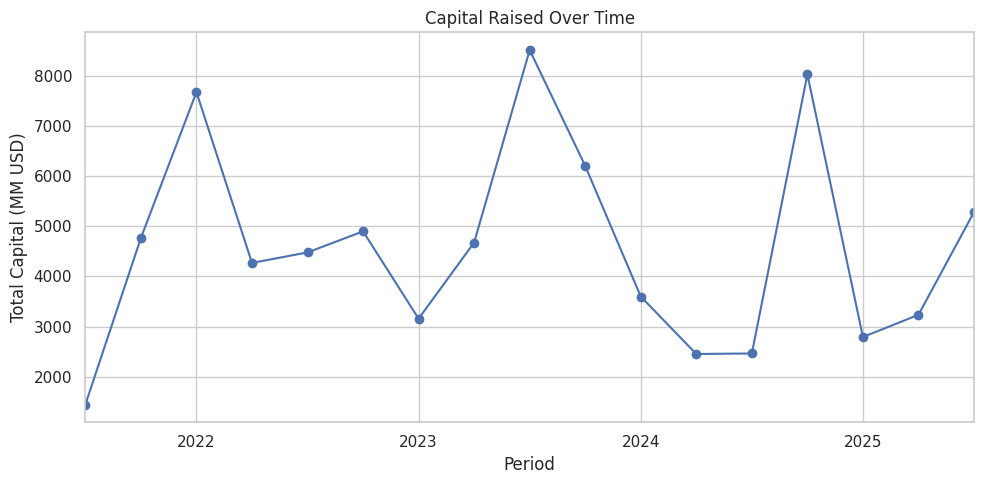

In [ ]:
# 5.1 Time Series: Capital Raised Over Time

def plot_capital_over_time(df, freq="Q"):
    if "funding_date" not in df.columns:
        print("funding_date not available.")
        return
    tmp = df.copy()
    tmp = tmp.dropna(subset=["funding_date"])
    tmp = tmp.set_index("funding_date").sort_index()
    ts = tmp["round_size_mm_usd"].resample(freq).sum(min_count=1)
    plt.figure(figsize=(10, 5))
    ts.plot(marker="o")
    plt.title("Capital Raised Over Time")
    plt.ylabel("Total Capital (MM USD)")
    plt.xlabel("Period")
    plt.tight_layout()
    plt.show()

plot_capital_over_time(df_deduped, freq="Q")


Saved figure: /content/cleaned_outputs/figures/5_2_stage_mix_percent.png


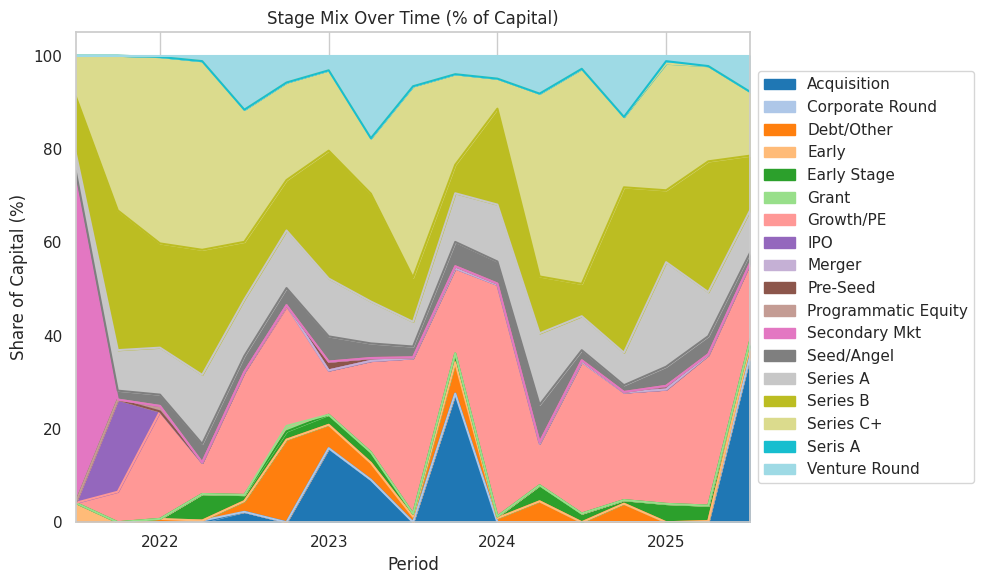

In [ ]:
# 5.2 Stage Mix Over Time (Stacked Area)

def plot_stage_mix(df, freq="Q", save=True):
    if not {"funding_date", "stage", "round_size_mm_usd"}.issubset(df.columns):
        print("Required columns missing.")
        return
    tmp = df.dropna(subset=["funding_date", "stage"]).copy()
    tmp = tmp.set_index("funding_date")
    agg = tmp.groupby([pd.Grouper(freq=freq), "stage"])["round_size_mm_usd"].sum().unstack(fill_value=0)
    agg_pct = agg.div(agg.sum(axis=1), axis=0) * 100
    ax = agg_pct.plot.area(figsize=(10, 6), cmap="tab20")
    plt.title("Stage Mix Over Time (% of Capital)")
    plt.ylabel("Share of Capital (%)")
    plt.xlabel("Period")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    if save: save_current_fig("5_2_stage_mix_percent")
    plt.show()

plot_stage_mix(df_deduped, freq="Q")


Saved figure: /content/cleaned_outputs/figures/5_3_round_size_distribution_by_stage_log.png


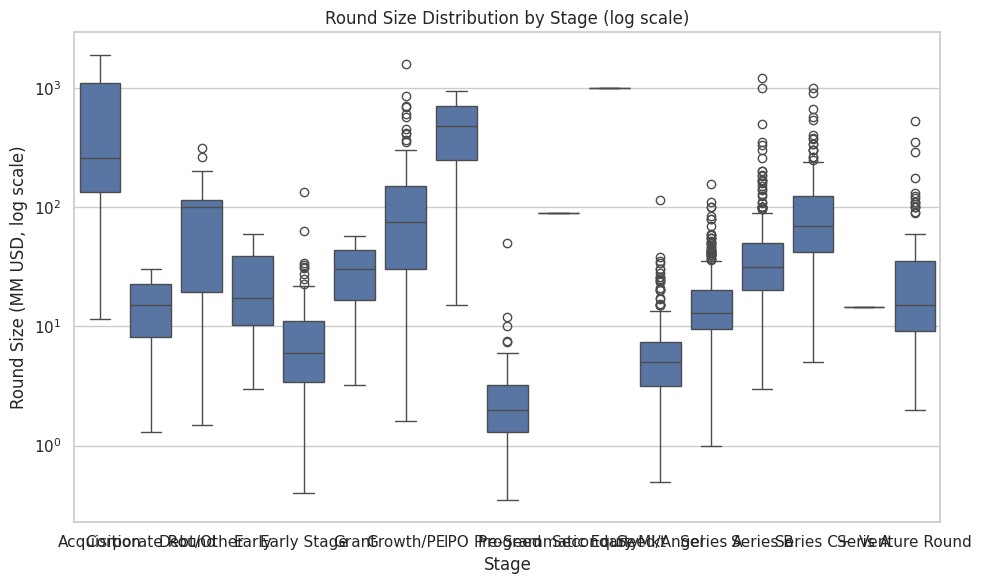

In [ ]:
# 5.3 Round Size Distribution by Stage

def plot_round_size_distribution(df, save=True):
    if not {"stage", "round_size_mm_usd"}.issubset(df.columns):
        print("Required columns missing.")
        return
    tmp = df.dropna(subset=["stage", "round_size_mm_usd"]).copy()
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=tmp, x="stage", y="round_size_mm_usd", order=sorted(tmp["stage"].unique()))
    plt.yscale("log")
    plt.title("Round Size Distribution by Stage (log scale)")
    plt.ylabel("Round Size (MM USD, log scale)")
    plt.xlabel("Stage")
    plt.tight_layout()
    if save: save_current_fig("5_3_round_size_distribution_by_stage_log")
    plt.show()

plot_round_size_distribution(df_deduped)

Saved figure: /content/cleaned_outputs/figures/5_4_top_sectors_by_capital.png


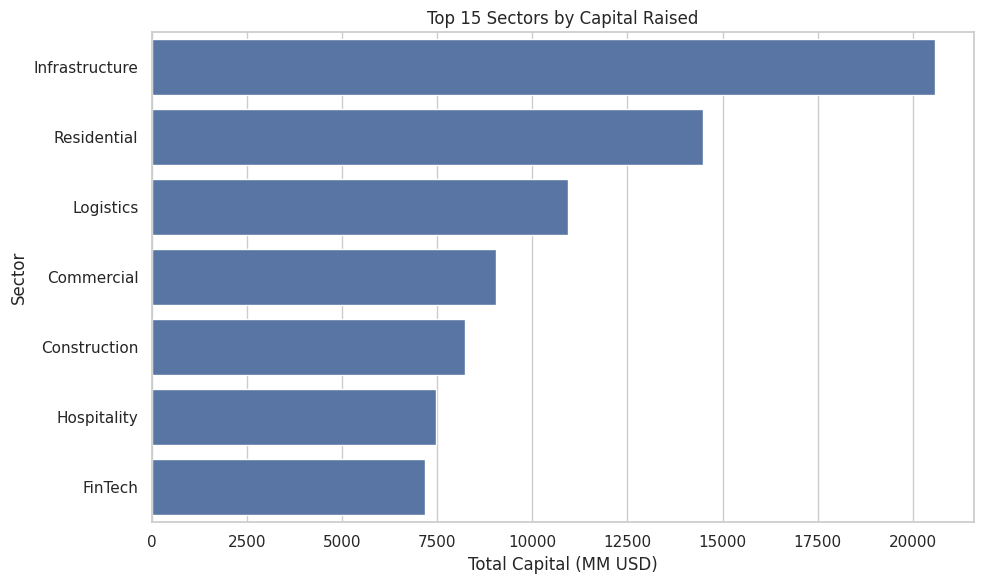

In [ ]:
# 5.4 Sector Capital Totals

def plot_sector_totals(df, top_n=15, save=True):
    if not {"sector", "round_size_mm_usd"}.issubset(df.columns):
        print("Required columns missing.")
        return
    g = df.groupby("sector")["round_size_mm_usd"].sum(min_count=1).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=g.values, y=g.index)
    plt.title(f"Top {top_n} Sectors by Capital Raised")
    plt.xlabel("Total Capital (MM USD)")
    plt.ylabel("Sector")
    plt.tight_layout()
    if save: save_current_fig("5_4_top_sectors_by_capital")
    plt.show()


plot_sector_totals(df_deduped, top_n=15)

Saved figure: /content/cleaned_outputs/figures/5_5_top_investors_by_attributed_capital_venture_only.png


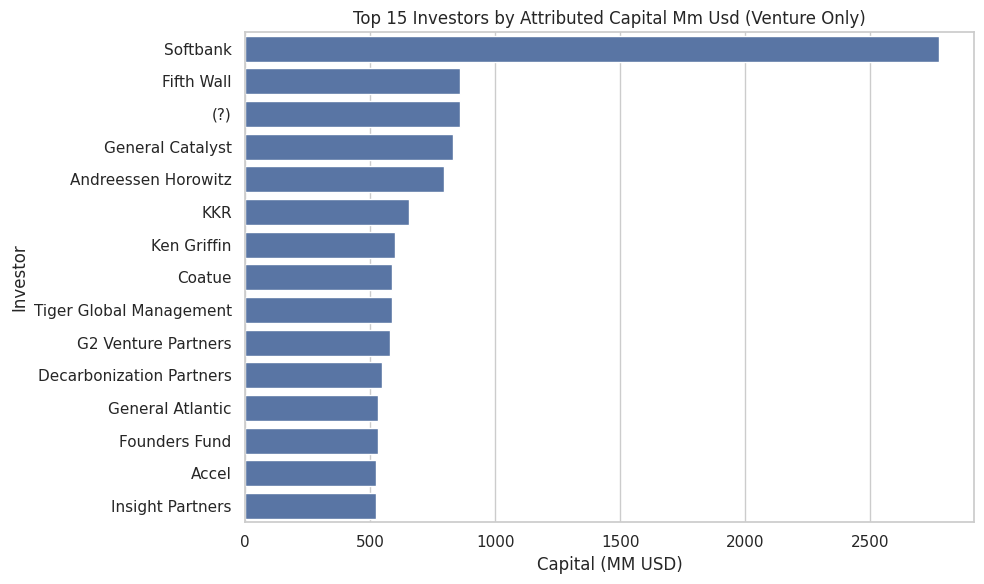

Saved figure: /content/cleaned_outputs/figures/5_5_top_investors_by_count_venture_only.png


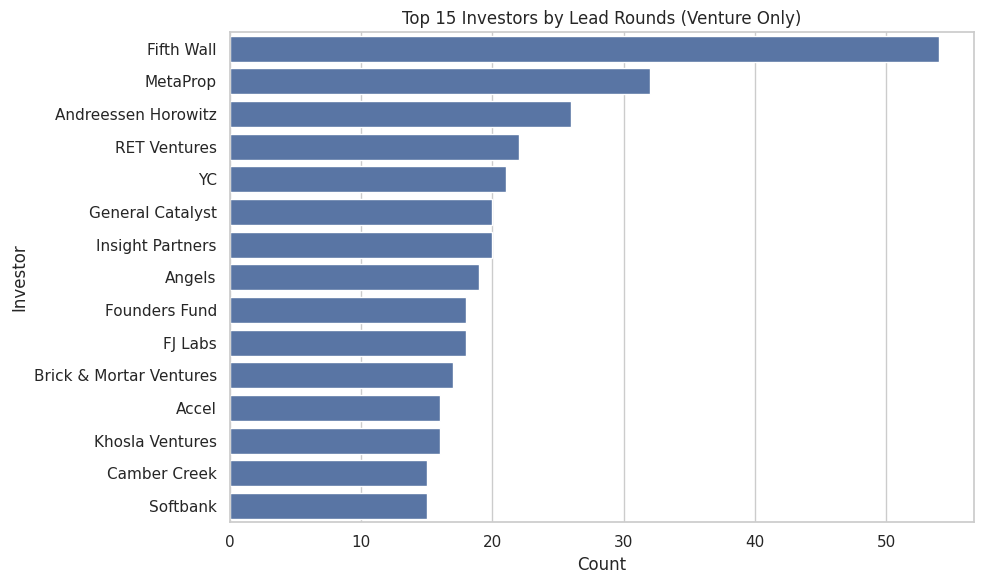

In [ ]:
# 5.5 Top Investors (venture only: exclude debt, acquisition, corporate)

def plot_top_venture_investors(df_inv, metric="attributed_capital_mm_usd", top_n=15, save=True):
    if df_inv.empty:
        print("Investor table is empty.")
        return
    if metric not in df_inv.columns and metric != "lead_rounds":
        print(f"Metric '{metric}' not found in investor table.")
        return

    pattern = re.compile(r"(debt|acqui|acquisition|corporate)", flags=re.IGNORECASE)
    df_v = df_inv.copy()
    df_v["stage_str"] = df_v["stage"].fillna("").astype(str)
    df_v = df_v[~df_v["stage_str"].str.contains(pattern)]
    df_v = df_v.drop(columns=["stage_str"])

    if df_v.empty:
        print("No venture rounds remain after filtering debt/acquisition/corporate.")
        return

    if metric == "lead_rounds":
        g = (df_v.groupby("investor")["company_name"]
                .count()
                .reset_index(name="lead_rounds")
                .sort_values("lead_rounds", ascending=False)
                .head(top_n))
        x_vals = "lead_rounds"; x_label = "Count"; title_metric = "Lead Rounds (Venture Only)"
        fname = "5_5_top_investors_by_count_venture_only"
    else:
        g = (df_v.groupby("investor")[metric]
                .sum(min_count=1)
                .reset_index()
                .sort_values(metric, ascending=False)
                .head(top_n))
        x_vals = metric; x_label = "Capital (MM USD)"; title_metric = metric.replace("_", " ").title() + " (Venture Only)"
        fname = "5_5_top_investors_by_attributed_capital_venture_only"

    plt.figure(figsize=(10, 6))
    sns.barplot(x=g[x_vals].values, y=g["investor"].values)
    plt.title(f"Top {top_n} Investors by {title_metric}")
    plt.xlabel(x_label)
    plt.ylabel("Investor")
    plt.tight_layout()
    if save: save_current_fig(fname)
    plt.show()



plot_top_venture_investors(df_investors, metric="attributed_capital_mm_usd", top_n=15)
plot_top_venture_investors(df_investors, metric="lead_rounds", top_n=15)


Saved figure: /content/cleaned_outputs/figures/5_6_deal_size_distribution_hist.png


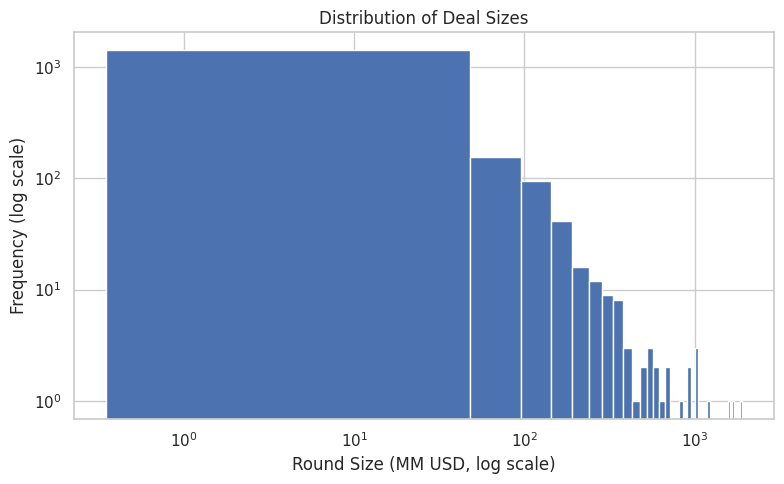

In [ ]:
# 5.6 Deal Size Distribution (Histogram, log scale)

def plot_deal_size_hist(df, save=True):
    if "round_size_mm_usd" not in df.columns:
        print("round_size_mm_usd not available.")
        return
    amt = pd.to_numeric(df["round_size_mm_usd"], errors="coerce").dropna()
    plt.figure(figsize=(8, 5))
    plt.hist(amt, bins=40, log=True)
    plt.xscale("log")
    plt.title("Distribution of Deal Sizes")
    plt.xlabel("Round Size (MM USD, log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.tight_layout()
    if save: save_current_fig("5_6_deal_size_distribution_hist")
    plt.show()

plot_deal_size_hist(df_deduped)

Saved figure: /content/cleaned_outputs/figures/5_7_yoy_growth.png


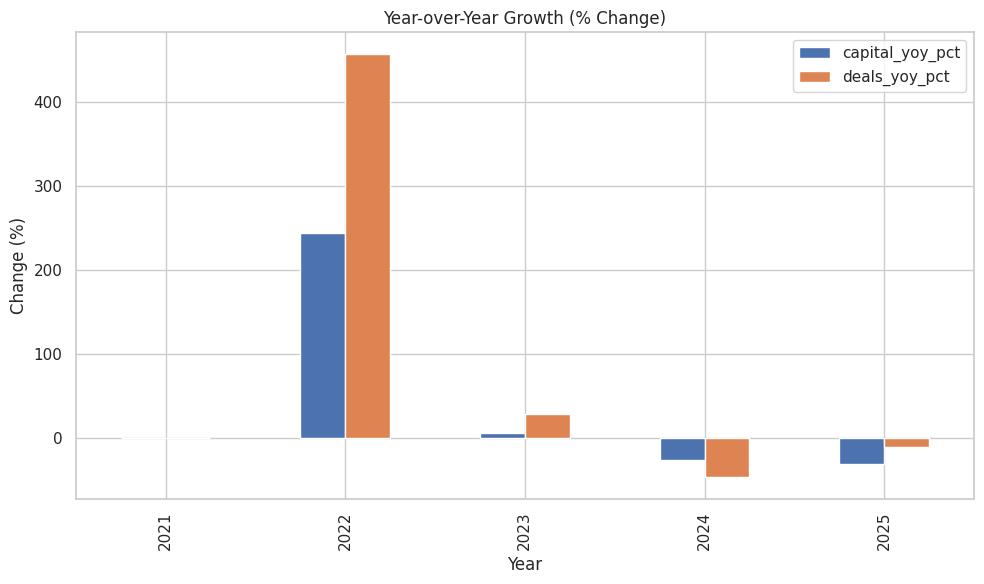

In [ ]:
# 5.7 Year-over-Year Growth

def plot_yoy_growth(df, save=True):
    if "year" not in df.columns:
        return
    g = df.groupby("year").agg(
        total_capital_mm_usd=("round_size_mm_usd", "sum"),
        deal_count=("company_name", "count")
    )
    g["capital_yoy_pct"] = g["total_capital_mm_usd"].pct_change() * 100
    g["deals_yoy_pct"] = g["deal_count"].pct_change() * 100
    ax = g[["capital_yoy_pct", "deals_yoy_pct"]].plot.bar(figsize=(10, 6))
    plt.title("Year-over-Year Growth (% Change)")
    plt.ylabel("Change (%)")
    plt.xlabel("Year")
    plt.tight_layout()
    if save: save_current_fig("5_7_yoy_growth")
    plt.show()

plot_yoy_growth(df_deduped)

Saved figure: /content/cleaned_outputs/figures/5_8_stage_medians_filtered.png


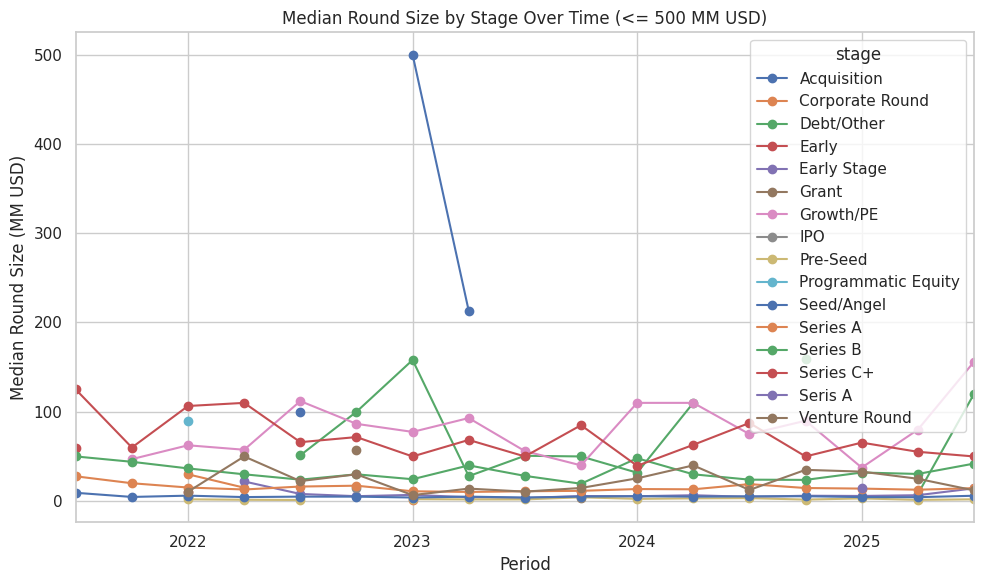

In [ ]:
# 5.8 Stage Evolution (Median Round Sizes Over Time)

def plot_stage_medians(df, freq="Y", max_round_mm=500.0, save=True):
    if not {"funding_date", "stage", "round_size_mm_usd"}.issubset(df.columns):
        return
    tmp = df.dropna(subset=["funding_date", "stage", "round_size_mm_usd"]).copy()
    tmp = tmp[tmp["round_size_mm_usd"] <= max_round_mm]
    if tmp.empty:
        print("No data after filtering by max round size.")
        return
    tmp = tmp.set_index("funding_date")
    med = tmp.groupby([pd.Grouper(freq=freq), "stage"])["round_size_mm_usd"].median().unstack()
    ax = med.plot(figsize=(10, 6), marker="o")
    plt.title(f"Median Round Size by Stage Over Time (<= {max_round_mm:.0f} MM USD)")
    plt.ylabel("Median Round Size (MM USD)")
    plt.xlabel("Period")
    plt.tight_layout()
    if save: save_current_fig("5_8_stage_medians_filtered")
    plt.show()

plot_stage_medians(df_deduped, freq="Q", max_round_mm=500.0, save=True)

Saved figure: /content/cleaned_outputs/figures/5_9_sector_momentum_last12_vs_prior12.png


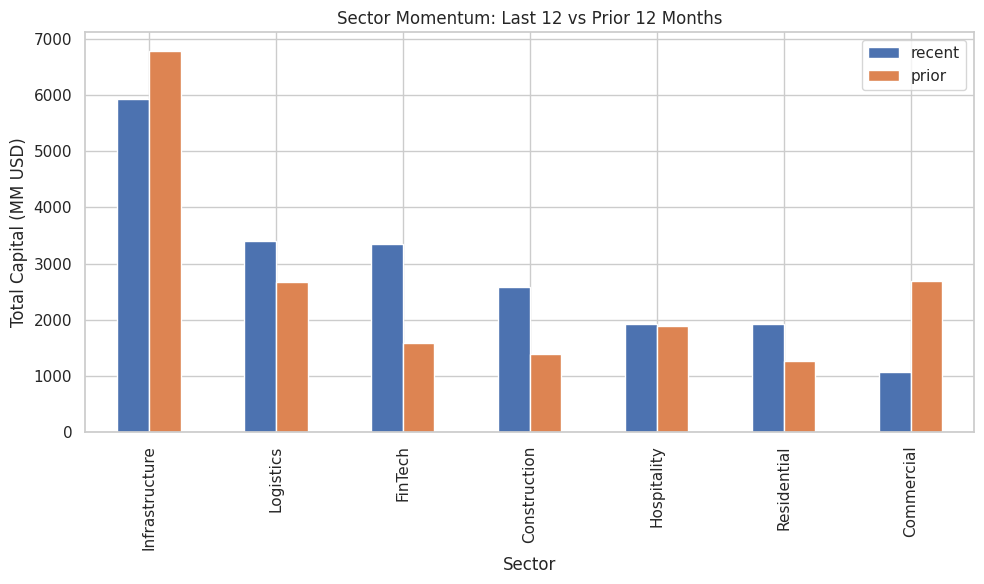

In [ ]:
# 5.9 Sector Momentum (Last 12 vs Prior 12 Months)

def plot_sector_momentum(df, lookback_months=12, save=True):
    if "funding_date" not in df or "sector" not in df:
        return
    max_date = df["funding_date"].max()
    if pd.isna(max_date): return
    recent_start = max_date - pd.DateOffset(months=lookback_months)
    prior_start = recent_start - pd.DateOffset(months=lookback_months)

    recent = df[(df["funding_date"] >= recent_start)]
    prior = df[(df["funding_date"] < recent_start) & (df["funding_date"] >= prior_start)]

    g_recent = recent.groupby("sector")["round_size_mm_usd"].sum().rename("recent")
    g_prior = prior.groupby("sector")["round_size_mm_usd"].sum().rename("prior")

    g = pd.concat([g_recent, g_prior], axis=1).fillna(0).sort_values("recent", ascending=False).head(15)
    ax = g.plot.bar(figsize=(10, 6))
    plt.title("Sector Momentum: Last 12 vs Prior 12 Months")
    plt.ylabel("Total Capital (MM USD)")
    plt.xlabel("Sector")
    plt.tight_layout()
    if save: save_current_fig("5_9_sector_momentum_last12_vs_prior12")
    plt.show()

plot_sector_momentum(df_deduped, lookback_months=12)

Saved figure: /content/cleaned_outputs/figures/5_10_investor_overlap_heatmap.png


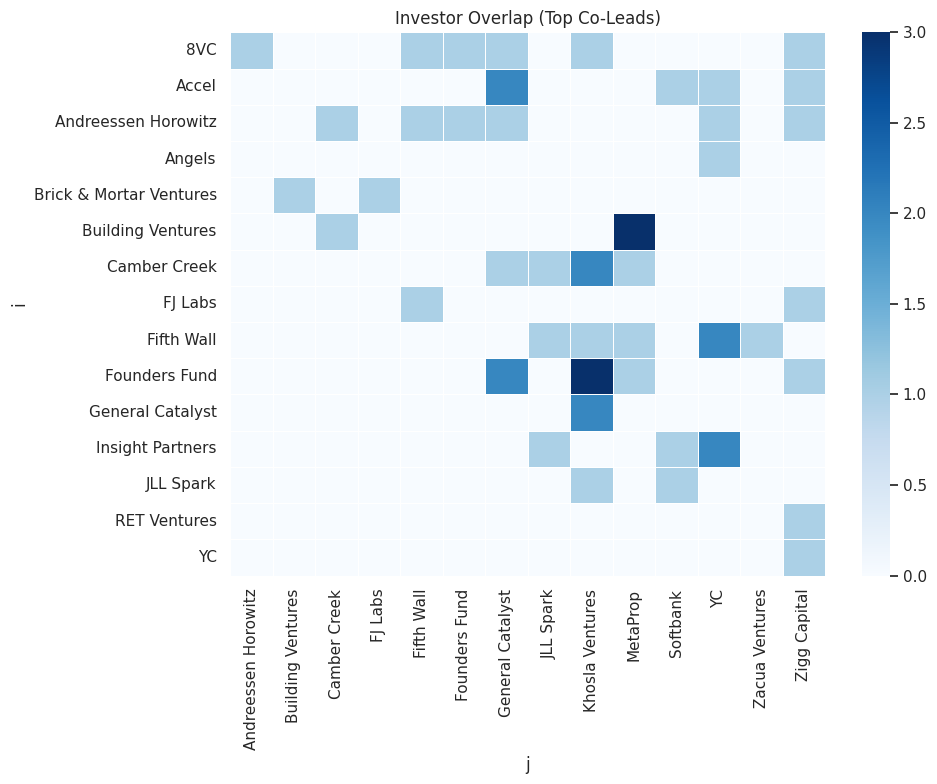

In [ ]:
# 5.10 Investor Overlap Heatmap (Top Co-Leads)

from itertools import combinations

def plot_investor_overlap(df_inv, top_n=20, save=True):
    if df_inv.empty: return
    top_investors = (df_inv.groupby("investor")["company_name"].count()
                            .sort_values(ascending=False).head(top_n).index)
    filt = df_inv[df_inv["investor"].isin(top_investors)]
    pairs = (filt.groupby(["company_name", "funding_date"])["investor"]
                 .apply(lambda x: sorted(set(x)))
                 .reset_index())
    edges = []
    for investors in pairs["investor"]:
        for a, b in combinations(investors, 2):
            edges.append((a, b))
    if not edges:
        print("No investor co-leads to display.")
        return
    co = pd.DataFrame(edges, columns=["i", "j"]).value_counts().reset_index(name="count")
    pivot = co.pivot(index="i", columns="j", values="count").fillna(0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap="Blues", linewidths=0.5)
    plt.title("Investor Overlap (Top Co-Leads)")
    plt.tight_layout()
    if save: save_current_fig("5_10_investor_overlap_heatmap")
    plt.show()

plot_investor_overlap(df_investors, top_n=20)

# 6. Trend & Insight Pass
# =========================================================

In [ ]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

CLEAN_DIR = "/content/cleaned_outputs"
os.makedirs(CLEAN_DIR, exist_ok=True)

# Safety: use cleaned dataset
df_trend = globals().get("df_deduped", df.copy()).copy()
df_inv_attrib = globals().get("df_investors", pd.DataFrame()).copy()

# Ensure datatypes
if "funding_date" in df_trend.columns and not np.issubdtype(df_trend["funding_date"].dtype, np.datetime64):
    df_trend["funding_date"] = pd.to_datetime(df_trend["funding_date"], errors="coerce")
if "round_size_mm_usd" in df_trend.columns:
    df_trend["round_size_mm_usd"] = pd.to_numeric(df_trend["round_size_mm_usd"], errors="coerce")
if "year" not in df_trend.columns and "funding_date" in df_trend.columns:
    df_trend["year"] = df_trend["funding_date"].dt.year

In [ ]:
# 6.1 KPIs by Year and YoY deltas

def compute_yoy(df):
    g = (df.groupby("year")
           .agg(total_capital_mm_usd=("round_size_mm_usd", "sum"),
                deal_count=("company_name", "count"),
                median_round_mm_usd=("round_size_mm_usd", "median"))
           .sort_index())
    g["capital_yoy_pct"] = g["total_capital_mm_usd"].pct_change() * 100
    g["deals_yoy_pct"] = g["deal_count"].pct_change() * 100
    g["median_round_yoy_pct"] = g["median_round_mm_usd"].pct_change() * 100
    return g.reset_index()

yoy_table = compute_yoy(df_trend)
display(yoy_table)
yoy_table.to_csv(os.path.join(CLEAN_DIR, "6_yoy_table.csv"), index=False)

,year,total_capital_mm_usd,deal_count,median_round_mm_usd,capital_yoy_pct,deals_yoy_pct,median_round_yoy_pct
0,2021,"6,213.65",87,31.00,NaN,NaN,NaN
1,2022,"21,333.97",485,20.00,243.34,457.47,-35.48
2,2023,"22,565.68",618,10.00,5.77,27.42,-50.00
3,2024,"16,549.50",324,17.10,-26.66,-47.57,71.00
4,2025,"11,312.66",287,14.00,-31.64,-11.42,-18.13


In [ ]:
# 6.2 Stage Drift: early vs late share over time

EARLY = {"Pre-Seed", "Seed/Angel", "Series A"}
LATE  = {"Series B", "Series C+", "Growth/PE"}
def stage_mix_over_time(df, freq="Y"):
    need = {"funding_date", "stage", "round_size_mm_usd"}
    if not need.issubset(df.columns):
        return pd.DataFrame()
    tmp = df.dropna(subset=["funding_date", "stage"]).copy()
    tmp = tmp.set_index("funding_date")
    agg = tmp.groupby([pd.Grouper(freq=freq), "stage"])["round_size_mm_usd"].sum().unstack(fill_value=0)
    agg["early_capital"] = agg.reindex(columns=[c for c in agg.columns if c in EARLY]).sum(axis=1)
    agg["late_capital"]  = agg.reindex(columns=[c for c in agg.columns if c in LATE]).sum(axis=1)
    agg["total"] = agg.sum(axis=1)
    agg["early_share_pct"] = np.where(agg["total"]>0, agg["early_capital"]/agg["total"]*100, np.nan)
    agg["late_share_pct"]  = np.where(agg["total"]>0, agg["late_capital"]/agg["total"]*100, np.nan)
    out = agg[["early_share_pct", "late_share_pct"]].reset_index().rename(columns={"funding_date":"period"})
    return out

stage_mix = stage_mix_over_time(df_trend, freq="Q")
display(stage_mix.tail(8))
stage_mix.to_csv(os.path.join(CLEAN_DIR, "6_stage_mix_over_time.csv"), index=False)

stage,period,early_share_pct,late_share_pct
9,2023-12-31,10.08,27.35
10,2024-03-31,8.87,39.54
11,2024-06-30,12.83,32.81
12,2024-09-30,5.00,43.80
13,2024-12-31,4.68,40.41
14,2025-03-31,14.04,34.51
15,2025-06-30,6.95,41.56
16,2025-09-30,7.41,27.22


In [ ]:
# 6.3 Sector Momentum: last 12 vs prior 12 months

def sector_momentum(df, lookback_months=12):
    if "funding_date" not in df or "sector" not in df:
        return pd.DataFrame()
    max_date = df["funding_date"].max()
    if pd.isna(max_date):
        return pd.DataFrame()
    recent_start = max_date - pd.DateOffset(months=lookback_months)
    prior_start = recent_start - pd.DateOffset(months=lookback_months)

    recent = df[df["funding_date"] >= recent_start]
    prior  = df[(df["funding_date"] < recent_start) & (df["funding_date"] >= prior_start)]
    r = recent.groupby("sector")["round_size_mm_usd"].sum().rename("recent")
    p = prior.groupby("sector")["round_size_mm_usd"].sum().rename("prior")
    g = pd.concat([r, p], axis=1).fillna(0)
    g["abs_change_mm"] = g["recent"] - g["prior"]
    g["pct_change"] = np.where(g["prior"]>0, g["abs_change_mm"]/g["prior"]*100, np.nan)
    g = g.sort_values(["abs_change_mm", "recent"], ascending=False).reset_index()
    return g

sector_mom = sector_momentum(df_trend, lookback_months=12)
display(sector_mom.head(15))
sector_mom.to_csv(os.path.join(CLEAN_DIR, "6_sector_momentum_last12_vs_prior12.csv"), index=False)

,sector,recent,prior,abs_change_mm,pct_change
0,FinTech,"3,349.42","1,591.71","1,757.70",110.43
1,Construction,"2,594.30","1,395.84","1,198.46",85.86
2,Logistics,"3,410.20","2,672.26",737.93,27.61
3,Residential,"1,919.45","1,277.41",642.04,50.26
4,Hospitality,"1,932.36","1,888.15",44.21,2.34
5,Infrastructure,"5,920.89","6,775.81",-854.92,-12.62
6,Commercial,"1,072.43","2,696.42","-1,623.99",-60.23


In [ ]:
# 6.4 Significant Rounds

def significant_rounds(df, top_pct=0.95, min_size_mm=None):
    amt = pd.to_numeric(df["round_size_mm_usd"], errors="coerce")
    thresh = np.nanquantile(amt, top_pct) if amt.notna().any() else None
    if min_size_mm is not None:
        thresh = max(thresh if thresh is not None else 0, min_size_mm)
    cols = [c for c in ["company_name","funding_date","stage","sector","round_size_mm_usd","lead_investors"] if c in df.columns]
    sig = df.loc[amt >= thresh, cols].sort_values("round_size_mm_usd", ascending=False) if thresh is not None else df.iloc[0:0]
    return sig, thresh

sig_rounds, sig_thresh = significant_rounds(df_trend, top_pct=0.95, min_size_mm=100)
print(f"Significant rounds threshold (MM USD): {sig_thresh:.2f}" if sig_thresh else "Threshold could not be computed.")
display(sig_rounds.head(20))
sig_rounds.to_csv(os.path.join(CLEAN_DIR, "6_significant_rounds.csv"), index=False)

Significant rounds threshold (MM USD): 160.00


,company_name,funding_date,stage,sector,round_size_mm_usd,lead_investors
1767,Domain Holdings,2025-08-01,Acquisition,FinTech,"1,900.00",CoStar Group
1076,SP Plus,2023-10-01,Acquisition,Commercial,"1,700.00",Metropolis
1014,H2 Green Steel,2023-09-01,Growth/PE,Infrastructure,"1,600.00","Altor, GIC, Hy24, Just Climate, Andra AP, AMF,..."
1498,GDS International,2024-12-01,Series B,Infrastructure,"1,200.00","Softbank, Ken Griffin"
1417,GDS,2024-10-01,Series B,Infrastructure,"1,000.00","Coatue, Baupost"
928,Redwood Materials,2023-08-01,Series C+,Infrastructure,"1,000.00","Goldman Sachs, Capricorn, T Rowe Price"
2,GoodLeap,2021-09-01,Secondary Mkt,Residential,"1,000.00",None
27,Oyo,2021-10-01,IPO,Hospitality,942.00,Softbank
966,Verkor,2023-09-01,Series C+,Infrastructure,908.20,"Macquarie, Meridiam, Renault"
109,Cloud Kitchens,2022-01-01,Growth/PE,Logistics,850.00,(?)


In [ ]:
# 6.5 Investor Dynamics: consistency and breadth (venture-only)

import re

def venture_only(df_inv):
    if df_inv.empty:
        return df_inv
    pat = re.compile(r"(debt|acqui|acquisition|corporate)", flags=re.IGNORECASE)
    tmp = df_inv.copy()
    tmp["stage_str"] = tmp["stage"].fillna("").astype(str)
    tmp = tmp[~tmp["stage_str"].str.contains(pat)]
    tmp = tmp.drop(columns=["stage_str"])
    return tmp

def investor_consistency(df_inv, min_years=2):
    if df_inv.empty:
        return pd.DataFrame()
    tmp = df_inv.copy()
    tmp["year"] = pd.to_datetime(tmp["funding_date"], errors="coerce").dt.year
    g = (tmp.groupby("investor")
            .agg(years_active=("year", lambda s: s.dropna().nunique()),
                 rounds=("company_name", "count"),
                 attributed_capital_mm_usd=("attributed_capital_mm_usd", "sum"))
            .reset_index())
    consistent = g[g["years_active"] >= min_years].sort_values(["years_active","rounds","attributed_capital_mm_usd"], ascending=False)
    return g.sort_values("rounds", ascending=False), consistent

df_inv_venture = venture_only(df_inv_attrib)
inv_all, inv_consistent = investor_consistency(df_inv_venture, min_years=2)
display(inv_all.head(20))
display(inv_consistent.head(20))
inv_all.to_csv(os.path.join(CLEAN_DIR, "6_investor_all_venture.csv"), index=False)
inv_consistent.to_csv(os.path.join(CLEAN_DIR, "6_investor_consistent_venture.csv"), index=False)

,investor,years_active,rounds,attributed_capital_mm_usd
1092,Fifth Wall,5,54,861.42
1912,MetaProp,5,32,130.63
241,Andreessen Horowitz,4,26,797.00
2373,RET Ventures,4,22,180.50
3229,YC,4,21,51.13
1256,General Catalyst,5,20,831.01
1551,Insight Partners,5,20,524.37
248,Angels,4,19,179.24
1172,Founders Fund,5,18,531.20
1069,FJ Labs,4,18,78.91


,investor,years_active,rounds,attributed_capital_mm_usd
1092,Fifth Wall,5,54,861.42
1912,MetaProp,5,32,130.63
1256,General Catalyst,5,20,831.01
1551,Insight Partners,5,20,524.37
1172,Founders Fund,5,18,531.20
592,Camber Creek,5,15,202.07
3248,Zigg Capital,5,13,119.80
1677,Kleiner Perkins,5,10,340.46
433,Bessemer Venture Partners,5,10,247.75
241,Andreessen Horowitz,4,26,797.00


In [ ]:
# 6.6 Narrative Generator

def _fmt(x, nd=1):
    if x is None or pd.isna(x):
        return "n/a"
    try:
        return f"{x:,.{nd}f}"
    except Exception:
        return str(x)

def generate_narrative(df, yoy, stage_mix_df, sector_mom_df, sig_df, sig_threshold, inv_all_df, inv_consistent_df, top_k=5):
    lines = []
    # Overall window
    if "funding_date" in df.columns:
        dmin, dmax = df["funding_date"].min(), df["funding_date"].max()
        lines.append(f"Coverage spans {dmin.date() if pd.notna(dmin) else 'n/a'} to {dmax.date() if pd.notna(dmax) else 'n/a'}.")

    # High-level totals
    total_cap = pd.to_numeric(df["round_size_mm_usd"], errors="coerce").sum(min_count=1)
    rounds = len(df)
    companies = df["company_name"].nunique(dropna=True) if "company_name" in df else None
    lines.append(f"Dataset includes {rounds:,} rounds across {companies:,} companies, totaling { _fmt(total_cap, nd=1) } MM USD.")

    # Most recent year YoY performance
    if not yoy.empty:
        last = yoy.sort_values("year").tail(2)
        if len(last) >= 2:
            recent = last.iloc[-1]
            lines.append(
                f"In {int(recent['year'])}, total capital was { _fmt(recent['total_capital_mm_usd'],1) } MM USD "
                f"({ _fmt(recent['capital_yoy_pct'],1) }% YoY), across { int(recent['deal_count']) } rounds "
                f"({ _fmt(recent['deals_yoy_pct'],1) }% YoY). Median round size YoY was { _fmt(recent['median_round_yoy_pct'],1) }%."
            )

    # Stage drift
    if not stage_mix_df.empty:
        last_two = stage_mix_df.tail(2)
        if len(last_two) == 2:
            e0, e1 = last_two.iloc[0]["early_share_pct"], last_two.iloc[1]["early_share_pct"]
            l0, l1 = last_two.iloc[0]["late_share_pct"],  last_two.iloc[1]["late_share_pct"]
            if pd.notna(e0) and pd.notna(e1):
                delta_e = e1 - e0
                lines.append(f"Early-stage share moved by { _fmt(delta_e,1) } percentage points in the latest period.")
            if pd.notna(l0) and pd.notna(l1):
                delta_l = l1 - l0
                lines.append(f"Late-stage share moved by { _fmt(delta_l,1) } percentage points in the latest period.")

    # Sector momentum
    if not sector_mom_df.empty:
        leaders = sector_mom_df.head(top_k)
        gainers = ", ".join([f"{row['sector']} (+{_fmt(row['abs_change_mm'],1)} MM)" for _, row in leaders.iterrows()])
        lines.append(f"Sectors leading the most recent 12-month capital totals versus the prior period: {gainers}.")

    # Significant rounds
    if sig_threshold is not None and not sig_df.empty:
        top_sig = sig_df.head(min(top_k, len(sig_df)))
        ex = []
        for _, r in top_sig.iterrows():
            comp = r.get("company_name", "n/a")
            amt  = _fmt(r.get("round_size_mm_usd"),1)
            stg  = r.get("stage","n/a")
            yr   = pd.to_datetime(r.get("funding_date")).year if pd.notna(r.get("funding_date")) else "n/a"
            ex.append(f"{comp} ({stg}, {yr}): {amt} MM")
        lines.append(f"Significant rounds (threshold about { _fmt(sig_threshold,1) } MM): " + "; ".join(ex) + ".")

    # Investor dynamics
    if not inv_all_df.empty:
        top_inv = inv_all_df.sort_values("attributed_capital_mm_usd", ascending=False).head(top_k)
        inv_str = ", ".join([f"{row['investor']} ({_fmt(row['attributed_capital_mm_usd'],1)} MM)" for _, row in top_inv.iterrows()])
        lines.append(f"Top investors by attributed venture dollars: {inv_str}.")
    if not inv_consistent_df.empty:
        cons = inv_consistent_df.head(top_k)
        cons_str = ", ".join([f"{row['investor']} ({int(row['years_active'])} yrs)" for _, row in cons.iterrows()])
        lines.append(f"Consistently active investors (appearing in at least 2 distinct years): {cons_str}.")

    return "\n".join(lines)

narrative_text = generate_narrative(
    df=df_trend,
    yoy=yoy_table,
    stage_mix_df=stage_mix,
    sector_mom_df=sector_mom,
    sig_df=sig_rounds,
    sig_threshold=sig_thresh,
    inv_all_df=inv_all,
    inv_consistent_df=inv_consistent,
    top_k=5
)
print(narrative_text)

# Save narrative
report_path = os.path.join(CLEAN_DIR, "6_insights_summary.md")
with open(report_path, "w") as f:
    f.write("# Proptech & Built World Funding — Insights Summary\n\n")
    f.write(narrative_text)
print(f"\nSaved narrative to: {report_path}")

Coverage spans 2021-09-01 to 2025-09-01.
Dataset includes 1,801 rounds across 1,546 companies, totaling 77,975.5 MM USD.
In 2025, total capital was 11,312.7 MM USD (-31.6% YoY), across 287 rounds (-11.4% YoY). Median round size YoY was -18.1%.
Early-stage share moved by 0.5 percentage points in the latest period.
Late-stage share moved by -14.3 percentage points in the latest period.
Sectors leading the most recent 12-month capital totals versus the prior period: FinTech (+1,757.7 MM), Construction (+1,198.5 MM), Logistics (+737.9 MM), Residential (+642.0 MM), Hospitality (+44.2 MM).
Significant rounds (threshold about 160.0 MM): Domain Holdings (Acquisition, 2025): 1,900.0 MM; SP Plus (Acquisition, 2023): 1,700.0 MM; H2 Green Steel (Growth/PE, 2023): 1,600.0 MM; GDS International (Series B, 2024): 1,200.0 MM; GDS (Series B, 2024): 1,000.0 MM.
Top investors by attributed venture dollars: Softbank (2,775.2 MM), Fifth Wall (861.4 MM), (?) (858.7 MM), General Catalyst (831.0 MM), Andreess

# 7. Sanity Checks & Reproducibility
# =========================================================

In [ ]:
import os
import sys
import json
import hashlib
import pandas as pd
import numpy as np

OUT_DIR = "/content/cleaned_outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

def file_digest(path, block_size=65536):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()[:16]

In [ ]:
# 7.1 Assertions on Data Integrity

def sanity_checks(df_rounds: pd.DataFrame, df_inv: pd.DataFrame):
    checks = {}

    # Required columns
    required_cols = ["company_name", "funding_date", "stage", "round_size_mm_usd", "sector"]
    checks["missing_required_cols"] = [c for c in required_cols if c not in df_rounds.columns]

    # Missingness in key fields
    key_missing = {c: int(df_rounds[c].isna().sum()) for c in required_cols if c in df_rounds.columns}
    checks["key_missing_counts"] = key_missing

    # Duplicates on conservative composite key
    dup_key = ["company_name", "funding_date", "stage", "round_size_mm_usd"]
    if all(c in df_rounds.columns for c in dup_key):
        dup_count = int(df_rounds.duplicated(subset=dup_key, keep=False).sum())
    else:
        dup_count = None
    checks["duplicate_count_conservative_key"] = dup_count

    # Date range
    if "funding_date" in df_rounds.columns:
        dmin = pd.to_datetime(df_rounds["funding_date"], errors="coerce").min()
        dmax = pd.to_datetime(df_rounds["funding_date"], errors="coerce").max()
        checks["date_range"] = (str(dmin.date()) if pd.notna(dmin) else None,
                                str(dmax.date()) if pd.notna(dmax) else None)

    # Amount sanity
    if "round_size_mm_usd" in df_rounds.columns:
        amt = pd.to_numeric(df_rounds["round_size_mm_usd"], errors="coerce")
        checks["rounds_count"] = int(len(df_rounds))
        checks["amount_non_null"] = int(amt.notna().sum())
        checks["amount_min_max"] = (float(amt.min()) if amt.notna().any() else None,
                                    float(amt.max()) if amt.notna().any() else None)

    # Investor table linkage sanity
    if not df_inv.empty and {"company_name","funding_date","investor"}.issubset(df_inv.columns):
        checks["investor_rows"] = int(len(df_inv))
        checks["investor_unique"] = int(df_inv["investor"].nunique())
        # Share of investor rows that align to rounds
        key = ["company_name", "funding_date"]
        aligned = df_inv.merge(df_rounds[key].drop_duplicates(), on=key, how="inner")
        checks["investor_alignment_rate_pct"] = round(len(aligned) / max(len(df_inv), 1) * 100, 2)

    return checks

sanity = sanity_checks(globals().get("df_deduped", pd.DataFrame()),
                       globals().get("df_investors", pd.DataFrame()))
print(json.dumps(sanity, indent=2))

{
  "missing_required_cols": [],
  "key_missing_counts": {
    "company_name": 0,
    "funding_date": 0,
    "stage": 0,
    "round_size_mm_usd": 25,
    "sector": 0
  },
  "duplicate_count_conservative_key": 0,
  "date_range": [
    "2021-09-01",
    "2025-09-01"
  ],
  "rounds_count": 1801,
  "amount_non_null": 1776,
  "amount_min_max": [
    0.35,
    1900.0
  ],
  "investor_rows": 5259,
  "investor_unique": 3340,
  "investor_alignment_rate_pct": 100.0
}


In [ ]:
# 7.2 Export final artifacts list and basic environment info

artifacts = []

# Data tables
for fname in [
    "cleaned_rounds.csv",
    "cleaned_investors.csv",
    "summary_overall.csv",
    "summary_by_year.csv",
    "summary_by_stage.csv",
    "summary_by_sector.csv",
    "top_investors_by_count.csv",
    "top_investors_by_attributed_dollars.csv",
    "top_companies_by_total.csv",
    "largest_rounds.csv",
    "6_yoy_table.csv",
    "6_stage_mix_over_time.csv",
    "6_sector_momentum_last12_vs_prior12.csv",
    "6_significant_rounds.csv",
    "6_investor_all_venture.csv",
    "6_investor_consistent_venture.csv",
    "6_insights_summary.md",
]:
    path = os.path.join(OUT_DIR, fname)
    if os.path.exists(path):
        artifacts.append({
            "path": path,
            "bytes": os.path.getsize(path),
            "sha256_16": file_digest(path)
        })

# Figures
if os.path.isdir(FIG_DIR):
    for f in sorted(os.listdir(FIG_DIR)):
        fp = os.path.join(FIG_DIR, f)
        if os.path.isfile(fp):
            artifacts.append({
                "path": fp,
                "bytes": os.path.getsize(fp),
                "sha256_16": file_digest(fp)
            })

env_info = {
    "python": sys.version.split()[0],
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": __import__("matplotlib").__version__,
    "seaborn": __import__("seaborn").__version__ if "seaborn" in sys.modules else None,
}

manifest = {
    "sanity_checks": sanity,
    "environment": env_info,
    "artifacts": artifacts
}

MANIFEST_PATH = os.path.join(OUT_DIR, "7_manifest.json")
with open(MANIFEST_PATH, "w") as f:
    json.dump(manifest, f, indent=2)

print(f"Manifest written to: {MANIFEST_PATH}")
print(f"Found {len(artifacts)} artifacts.")

Manifest written to: /content/cleaned_outputs/7_manifest.json
Found 26 artifacts.


In [ ]:
# 7.3 Lightweight README for re-running

README_PATH = os.path.join(OUT_DIR, "README_REPRODUCIBILITY.md")
readme = f"""# Proptech & Built World Funding — Reproducibility

This directory contains cleaned data, summary tables, figures, and a minimal manifest to verify outputs.

## How to Re-run

1. Place the source Excel file at the path set in Section 1 (`CONFIG["excel_file_path"]`), or update that path.
2. Run the notebook top to bottom:
   - Section 1: Setup & Config
   - Section 2: Data Ingest & Schema Check
   - Section 3: Cleaning Pipeline
   - Section 3.A: Investor Attribution
   - Section 4: Descriptive Summary
   - Section 5: Visualizations
   - Section 6: Trend & Insight Pass
   - Section 7: Sanity Checks & Reproducibility

## Expected Outputs

- Cleaned datasets: `cleaned_rounds.csv`, `cleaned_investors.csv`
- Summary tables: `summary_*.csv`, `6_*.csv`
- Figures: PNG files under `figures/`
- Narrative: `6_insights_summary.md`
- Manifest with checksums and environment: `7_manifest.json`

## Notes

- Sectors are normalized to a canonical taxonomy (Multifamily → Residential; Fulfillment/Delivery → Logistics; Parking/Access Control → Commercial; finance-related sectors → FinTech).
- Investor attribution splits round capital equally across listed lead investors after cleaning aliases and removing placeholders.

"""

with open(README_PATH, "w") as f:
    f.write(readme)

print(f"README written to: {README_PATH}")

README written to: /content/cleaned_outputs/README_REPRODUCIBILITY.md


In [ ]:
# 7.4 Quick checklist output

def run_checklist():
    results = []
    # Files that should exist at minimum
    must_have = [
        "cleaned_rounds.csv",
        "cleaned_investors.csv",
        "summary_overall.csv",
        "6_insights_summary.md",
    ]
    for fname in must_have:
        path = os.path.join(OUT_DIR, fname)
        results.append((fname, os.path.exists(path)))
    return pd.DataFrame(results, columns=["artifact", "exists"])

checklist = run_checklist()
display(checklist)

,artifact,exists
0,cleaned_rounds.csv,True
1,cleaned_investors.csv,True
2,summary_overall.csv,True
3,6_insights_summary.md,True


# 8. Appendix
# =========================================================

In [ ]:
# 8.1 Stage mapping reference
STAGE_CANON_MAP_REF = {
    "Pre-Seed": ["pre-seed", "angel"],
    "Seed/Angel": ["seed"],
    "Series A": ["series a"],
    "Series B": ["series b"],
    "Series C+": ["series c", "series d", "series e", "series f", "series g", "series h"],
    "Growth/PE": ["growth", "late", "mezzanine", "pre-ipo", "private equity", "pe"],
    "Debt/Other": ["debt", "venture debt", "convertible", "note", "safe"],
}
display(pd.DataFrame([
    {"canonical": k, "examples": ", ".join(v)} for k, v in STAGE_CANON_MAP_REF.items()
]))

,canonical,examples
0,Pre-Seed,"pre-seed, angel"
1,Seed/Angel,seed
2,Series A,series a
3,Series B,series b
4,Series C+,"series c, series d, series e, series f, series..."
5,Growth/PE,"growth, late, mezzanine, pre-ipo, private equi..."
6,Debt/Other,"debt, venture debt, convertible, note, safe"


In [ ]:
# 8.2 Sector mapping reference
SECTOR_ALIAS_MAP_REF = {
    "Residential": ["multifamily", "single-family", "residential"],
    "Commercial": ["commercial real estate", "cre", "office", "retail", "parking", "access control"],
    "Construction": ["construction tech", "contech", "construction"],
    "Industrial": ["industrial", "warehouse"],
    "Property Management": ["property management", "operations", "ops"],
    "FinTech": ["mortgage", "lending", "finance", "fintech", "capital"],
    "Maintenance": ["maintenance", "repairs", "service"],
    "Marketplace": ["brokerage", "marketplace", "leasing"],
    "Climate/Energy": ["climate", "energy", "sustainability", "decarbonization"],
    "IoT/Hardware": ["smart home", "iot", "hardware"],
    "Data/AI": ["data", "analytics", "ai", "ml"],
    "Logistics": ["fulfillment", "delivery"],
}
display(pd.DataFrame([
    {"canonical": k, "examples": ", ".join(v)} for k, v in SECTOR_ALIAS_MAP_REF.items()
]))


,canonical,examples
0,Residential,"multifamily, single-family, residential"
1,Commercial,"commercial real estate, cre, office, retail, p..."
2,Construction,"construction tech, contech, construction"
3,Industrial,"industrial, warehouse"
4,Property Management,"property management, operations, ops"
5,FinTech,"mortgage, lending, finance, fintech, capital"
6,Maintenance,"maintenance, repairs, service"
7,Marketplace,"brokerage, marketplace, leasing"
8,Climate/Energy,"climate, energy, sustainability, decarbonization"
9,IoT/Hardware,"smart home, iot, hardware"


In [ ]:
# 8.3 Investor alias reference
INVESTOR_ALIAS_MAP_REF = {
    "Insight": "Insight Partners",
    "a16z": "Andreessen Horowitz",
    "sequoia": "Sequoia Capital",
    "Brick + Mortar Ventures": "Brick & Mortar Ventures",
    "Brick and Mortar Ventures": "Brick & Mortar Ventures",
    "Brick & Mortar": "Brick & Mortar Ventures",
}
display(pd.DataFrame([
    {"alias": k, "canonical": v} for k, v in INVESTOR_ALIAS_MAP_REF.items()
]))


,alias,canonical
0,Insight,Insight Partners
1,a16z,Andreessen Horowitz
2,sequoia,Sequoia Capital
3,Brick + Mortar Ventures,Brick & Mortar Ventures
4,Brick and Mortar Ventures,Brick & Mortar Ventures
5,Brick & Mortar,Brick & Mortar Ventures


In [ ]:
# 8.4 Utility functions list
UTILITY_FUNCS = [
    "quick_data_summary(df, date_col, amount_col, preview_rows)",
    "standardize_columns(df, schema_map)",
    "parse_amount_millions(x) -> (amount, is_estimated, is_undisclosed)",
    "parse_funding_date(x) -> pd.Timestamp",
    "normalize_stage(s)",
    "normalize_sector(s)",
    "normalize_investor_name(s)",
    "preprocess_investor_list(s)",
    "explode_investors(df, col)",
    "build_investor_table_with_attribution(df, investors_col, amount_col)",
    "dedupe_rounds(df, date_col, amount_col, by, date_tolerance_days, amount_tolerance)",
]
print("Utility functions defined in this notebook:")
for f in UTILITY_FUNCS:
    print(" -", f)

Utility functions defined in this notebook:
 - quick_data_summary(df, date_col, amount_col, preview_rows)
 - standardize_columns(df, schema_map)
 - parse_amount_millions(x) -> (amount, is_estimated, is_undisclosed)
 - parse_funding_date(x) -> pd.Timestamp
 - normalize_stage(s)
 - normalize_sector(s)
 - normalize_investor_name(s)
 - preprocess_investor_list(s)
 - explode_investors(df, col)
 - build_investor_table_with_attribution(df, investors_col, amount_col)
 - dedupe_rounds(df, date_col, amount_col, by, date_tolerance_days, amount_tolerance)


In [ ]:
# 8.5 Reproducibility reminder
print("""
Appendix Notes:
- Stage, sector, and investor mappings are defined centrally here.
- If new categories emerge in future data, extend the alias maps.
- Utility functions are reusable for new datasets.
""")


Appendix Notes:
- Stage, sector, and investor mappings are defined centrally here.
- If new categories emerge in future data, extend the alias maps.
- Utility functions are reusable for new datasets.



In [ ]:
# 8. Appendix — Multi-page PDF Export (with all figures)


import os
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import utils
from PIL import Image as PILImage

OUT_DIR = "/content/cleaned_outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
APPENDIX_PDF = os.path.join(OUT_DIR, "PropTech_Funding_Appendix.pdf")

styles = getSampleStyleSheet()

def _para(text, style="Normal"):
    return Paragraph(text, styles[style])

def _image_flowable(path, max_width=500, max_height=360):
    # Preserve aspect ratio and constrain to max dimensions
    with PILImage.open(path) as im:
        w, h = im.size
    ratio = min(max_width / w, max_height / h)
    return Image(path, width=w*ratio, height=h*ratio)

story = []
story.append(_para("Proptech & Built World Funding — Appendix", "Title"))
story.append(Spacer(1, 12))

# Insights narrative
narrative_path = os.path.join(OUT_DIR, "6_insights_summary.md")
if os.path.exists(narrative_path):
    story.append(_para("Insights Narrative", "Heading2"))
    with open(narrative_path, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                story.append(_para(line))
    story.append(Spacer(1, 12))

# README
readme_path = os.path.join(OUT_DIR, "README_REPRODUCIBILITY.md")
if os.path.exists(readme_path):
    story.append(_para("Reproducibility README", "Heading2"))
    with open(readme_path, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                story.append(_para(line))
    story.append(Spacer(1, 12))

# Mapping tables (expect these dicts defined in Section 8)
def _table_from_mapping(title, header, rows):
    story.append(_para(title, "Heading2"))
    data = [header] + rows
    story.append(Table(data))
    story.append(Spacer(1, 12))

# Stage mapping table
if "STAGE_CANON_MAP_REF" in globals():
    _table_from_mapping(
        "Stage Mapping Reference",
        ["Canonical Stage", "Examples"],
        [[k, ", ".join(v)] for k, v in STAGE_CANON_MAP_REF.items()]
    )

# Sector mapping table
if "SECTOR_ALIAS_MAP_REF" in globals():
    _table_from_mapping(
        "Sector Mapping Reference",
        ["Canonical Sector", "Examples"],
        [[k, ", ".join(v)] for k, v in SECTOR_ALIAS_MAP_REF.items()]
    )

# Investor alias table
if "INVESTOR_ALIAS_MAP_REF" in globals():
    _table_from_mapping(
        "Investor Alias Reference",
        ["Alias", "Canonical"],
        [[k, v] for k, v in INVESTOR_ALIAS_MAP_REF.items()]
    )

# Utility function list
if "UTILITY_FUNCS" in globals():
    story.append(_para("Utility Functions Defined", "Heading2"))
    for f in UTILITY_FUNCS:
        story.append(_para(f"- {f}"))

# Page break before figures
story.append(PageBreak())

# Include all figures (sorted by filename)
story.append(_para("Figures", "Heading2"))
if os.path.isdir(FIG_DIR):
    figs = sorted([f for f in os.listdir(FIG_DIR) if f.lower().endswith(".png")])
    if figs:
        for i, fname in enumerate(figs, 1):
            fpath = os.path.join(FIG_DIR, fname)
            story.append(_para(fname, "Heading3"))
            story.append(_image_flowable(fpath, max_width=500, max_height=360))
            story.append(Spacer(1, 12))
            # Add a page break every ~3 figures for readability
            if i % 3 == 0 and i < len(figs):
                story.append(PageBreak())
    else:
        story.append(_para("No figures found in the figures/ directory."))
else:
    story.append(_para("Figures directory not found."))

# Build the PDF
doc = SimpleDocTemplate(APPENDIX_PDF, pagesize=letter)
doc.build(story)
print(f"PDF Appendix created at: {APPENDIX_PDF}")

PDF Appendix created at: /content/cleaned_outputs/PropTech_Funding_Appendix.pdf


In [ ]:
APPENDIX_PDF = os.path.join(OUT_DIR, "PropTech_Funding_Appendix.pdf")

# Save into Drive + trigger local download
save_both(APPENDIX_PDF)

Copied to Google Drive: /content/drive/My Drive/PropTech_Data/exports/PropTech_Funding_Appendix.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>